# Neural newtorks (Veštačke neuronske mreže)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.preprocessing import MinMaxScaler

C:\Users\marko\miniconda3\envs\ml_tf\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
df = pd.read_csv('../london_weather.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


## Opis karakteristika
| Karakteristika | Opis
| -------- | ------- |
| date | Datum merenja |
| cloud_cover | Oblačnost merena u oktama |
| sunshine | Broj sunčanih sati u danu |
| global_radiation | Zračenje mereno u vatima po metru kvadratnom |
| max_temp  | Maksimalna temperatura u toku dana |
| mean_temp  | Srednja temperatura u toku dana   |
| min_temp |  Minimalna temperatura u toku dana |
| precipitation |  Padavine izražene u milimetrima   |
| pressure | Atmosferski pritisak izražen u Paskalima  |
| snow_depth | Visina snežnog pokrivača u milimetrima   |

In [3]:
df['date'].head()

0    19790101
1    19790102
2    19790103
3    19790104
4    19790105
Name: date, dtype: int64

In [4]:
if not isinstance(df.index, pd.DatetimeIndex):
    df['date']= pd.to_datetime(df['date'],format='%Y%m%d',errors='coerce')
    df = df.set_index("date")


In [5]:
print(f"🗓️ Starting date: {df.index.min().strftime('%Y-%m-%d')}")
print(f"🗓️ Ending date:   {df.index.max().strftime('%Y-%m-%d')}")

🗓️ Starting date: 1979-01-01
🗓️ Ending date:   2020-12-31


In [6]:
df.isna().sum().sort_values(ascending=False)

snow_depth          1441
mean_temp             36
cloud_cover           19
global_radiation      19
max_temp               6
precipitation          6
pressure               4
min_temp               2
sunshine               0
dtype: int64

In [7]:
df['snow_depth']=df['snow_depth'].fillna(0) # ukoliko nema podatka, nema ni snega

interp_cols = ['max_temp','min_temp','mean_temp','pressure','global_radiation','cloud_cover',"precipitation"]

df[interp_cols] = (df[interp_cols]
    .interpolate(method='time', limit=3, limit_direction='both')
    .ffill()
    .bfill()
)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15341 entries, 1979-01-01 to 2020-12-31
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cloud_cover       15341 non-null  float64
 1   sunshine          15341 non-null  float64
 2   global_radiation  15341 non-null  float64
 3   max_temp          15341 non-null  float64
 4   mean_temp         15341 non-null  float64
 5   min_temp          15341 non-null  float64
 6   precipitation     15341 non-null  float64
 7   pressure          15341 non-null  float64
 8   snow_depth        15341 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


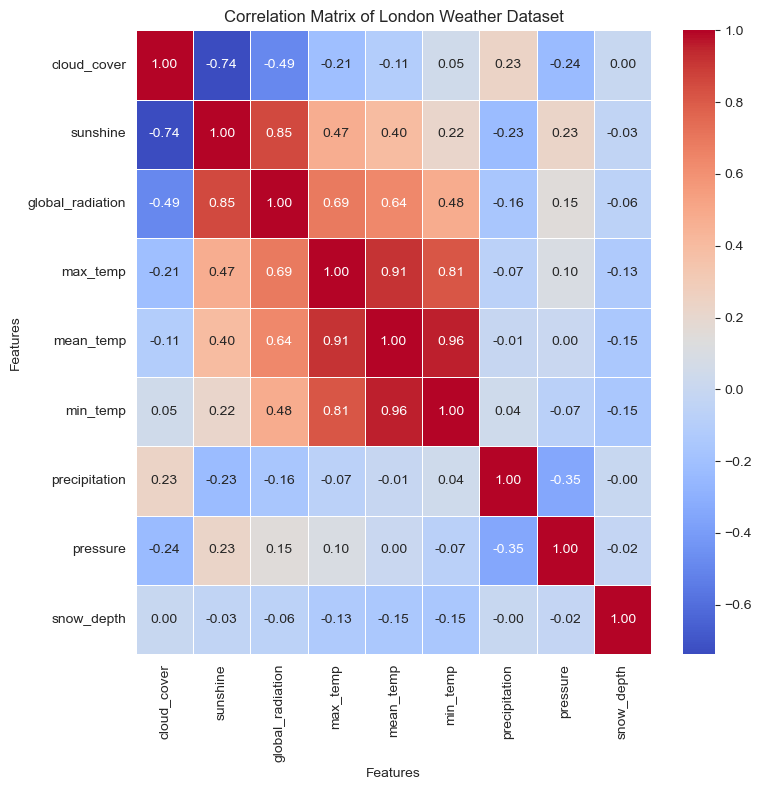

In [9]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(8, 8))
seaborn.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of London Weather Dataset")
plt.xlabel("Features")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

##  Pregled pojedinih karakteristika 

Maksimalna, srednja i minimalna temperatura u poslednjih 10 godina

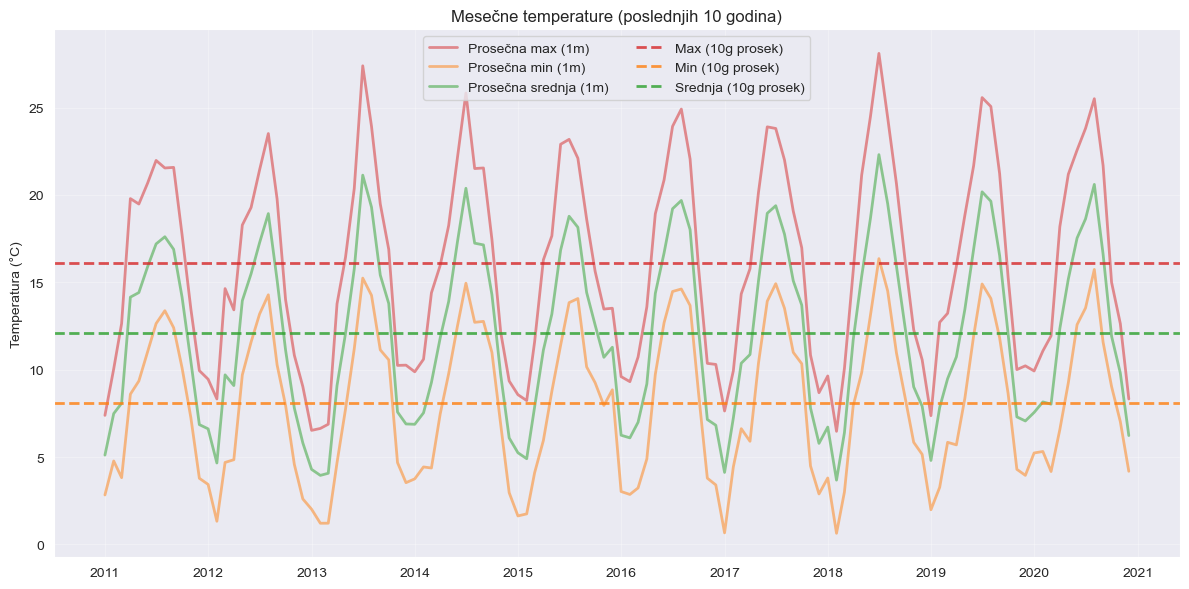

In [10]:
M = df[['max_temp', 'min_temp', 'mean_temp']].resample('MS').mean()

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)
Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['max_temp'],  alpha=0.5, lw=2, label='Prosečna max (1m)', color='tab:red')
ax.plot(Mw.index, Mw['min_temp'],  alpha=0.5, lw=2, label='Prosečna min (1m)', color='tab:orange')
ax.plot(Mw.index, Mw['mean_temp'], alpha=0.5, lw=2, label='Prosečna srednja (1m)', color='tab:green')

ax.axhline(Mw['max_temp'].mean(),  color='tab:red',   ls='--', lw=2, alpha=0.8, label='Max (10g prosek)')
ax.axhline(Mw['min_temp'].mean(),  color='tab:orange',ls='--', lw=2, alpha=0.8, label='Min (10g prosek)')
ax.axhline(Mw['mean_temp'].mean(), color='tab:green', ls='--', lw=2, alpha=0.8, label='Srednja (10g prosek)')

ax.set_title('Mesečne temperature (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Temperatura (°C)')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, loc='upper center')
plt.tight_layout()
plt.show()


Pritisak

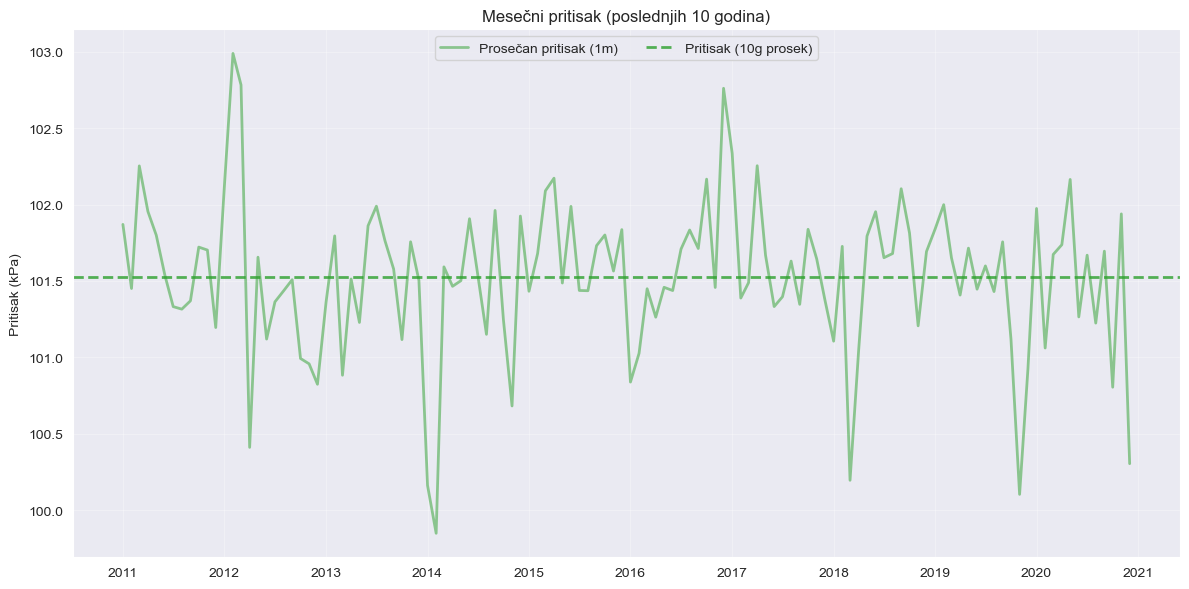

In [11]:
M = df[['pressure']].resample('MS').mean()/1000 # pretvaranje u kPa

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)

Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['pressure'],  alpha=0.5, lw=2, label='Prosečan pritisak (1m)', color='tab:green')

ax.axhline(Mw['pressure'].mean(),  color='tab:green',   ls='--', lw=2, alpha=0.8, label='Pritisak (10g prosek)')

ax.set_title('Mesečni pritisak (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Pritisak (kPa)')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=3, loc='upper center')
plt.tight_layout()
plt.show()


Padavine

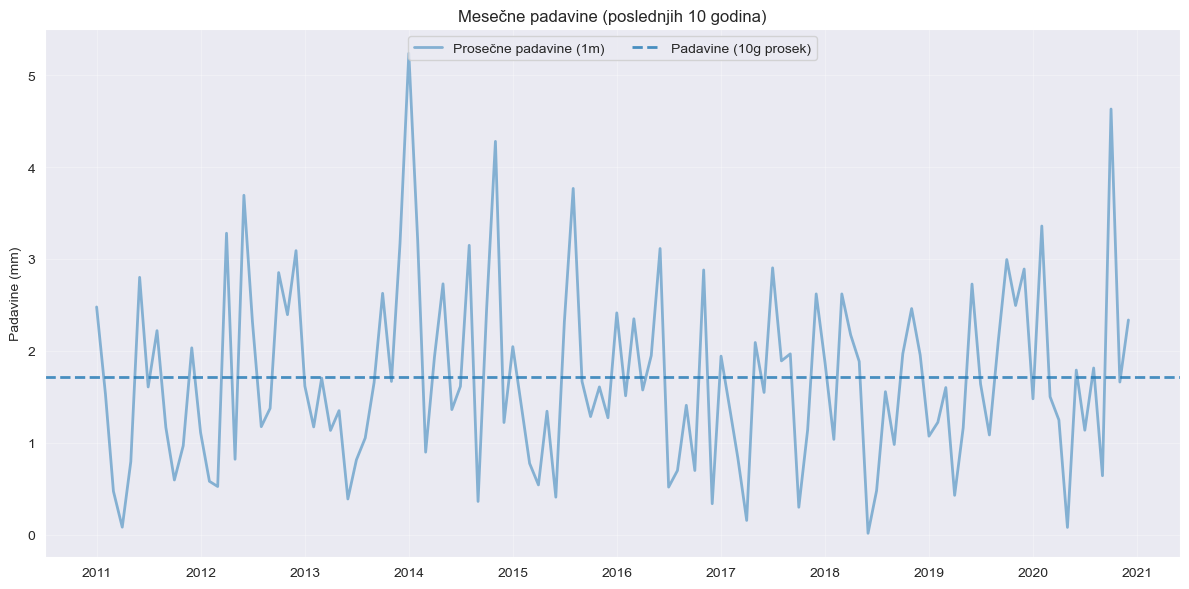

In [12]:
M = df[['precipitation']].resample('MS').mean()

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)

Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['precipitation'],  alpha=0.5, lw=2,label='Prosečne padavine (1m)', color='tab:blue')

ax.axhline(Mw['precipitation'].mean(),  color='tab:blue',   ls='--', lw=2, alpha=0.8, label='Padavine (10g prosek)')

ax.set_title('Mesečne padavine (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Padavine (mm)')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, loc='upper center')
plt.tight_layout()
plt.show()


Snežni pokrivač

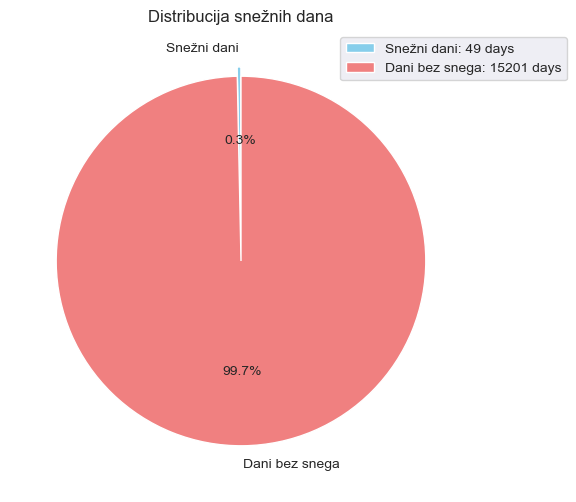

In [13]:
snow_counts = pd.Series({
    "Snežni dani": df['snow_depth'].where(lambda x: x>0).value_counts().values[0],
    "Dani bez snega": df['snow_depth'].where(lambda x: x==0).value_counts().values[0]
})

plt.figure(figsize=(6, 6))
snow_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=["skyblue", "lightcoral"],
    explode=(0.05, 0)
)
plt.title("Distribucija snežnih dana")
labels = [f"{cat}: {count} days" for cat, count in snow_counts.items()]
plt.legend(labels,bbox_to_anchor=(0.7, 1))
plt.show()

Radijacija Sunca

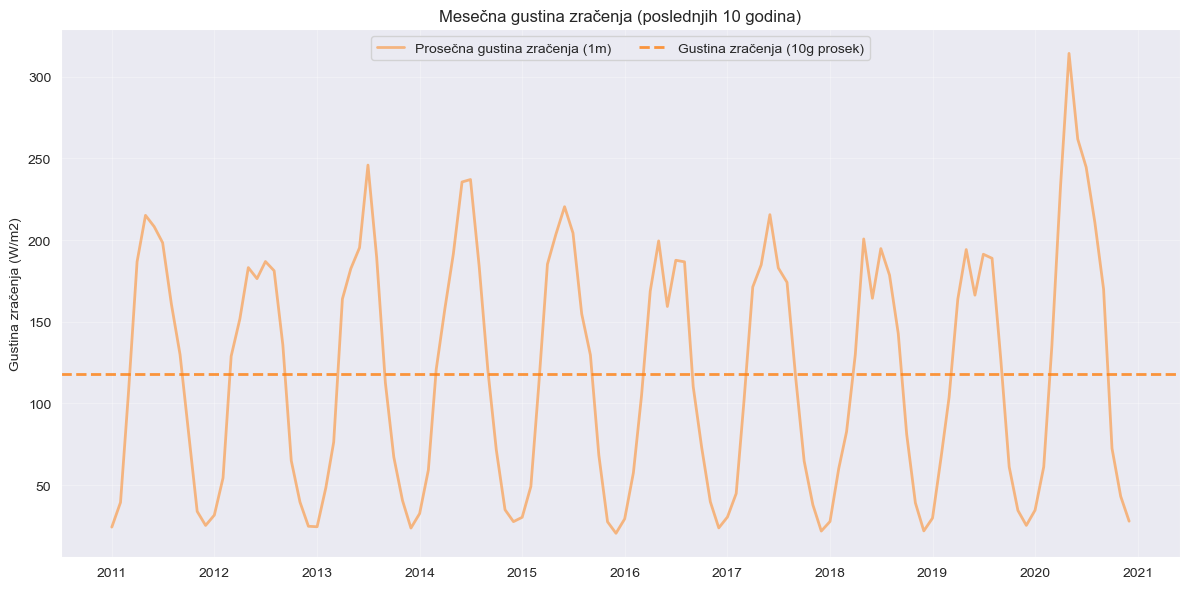

In [14]:
M = df[['global_radiation']].resample('MS').mean()

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)

Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['global_radiation'],  alpha=0.5, lw=2,label='Prosečna gustina zračenja (1m)', color='tab:orange')

ax.axhline(Mw['global_radiation'].mean(),  color='tab:orange',   ls='--', lw=2, alpha=0.8, label='Gustina zračenja (10g prosek)')

ax.set_title('Mesečna gustina zračenja (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Gustina zračenja (W/m2)')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, loc='upper center')
plt.tight_layout()
plt.show()


Pokrivenost oblacima

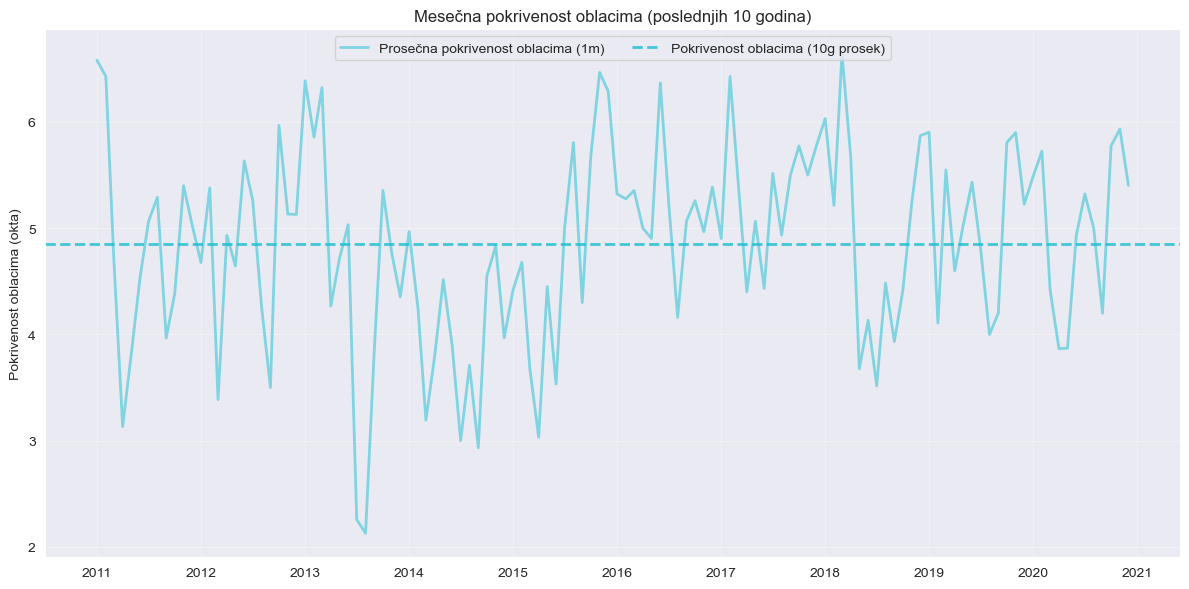

In [15]:
M = df[['cloud_cover']].resample('MS').mean()

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)

Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['cloud_cover'],  alpha=0.5, lw=2,label='Prosečna pokrivenost oblacima (1m)', color='tab:cyan')

ax.axhline(Mw['cloud_cover'].mean(),  color='tab:cyan',   ls='--', lw=2, alpha=0.8, label='Pokrivenost oblacima (10g prosek)')

ax.set_title('Mesečna pokrivenost oblacima (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Pokrivenost oblacima (okta)') # okta: 0-8 skala za pokrivenost oblacima (0=bez oblaka, 8=potpuno oblačno)

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, loc='upper center')
plt.tight_layout()
plt.show()


Osunčanost

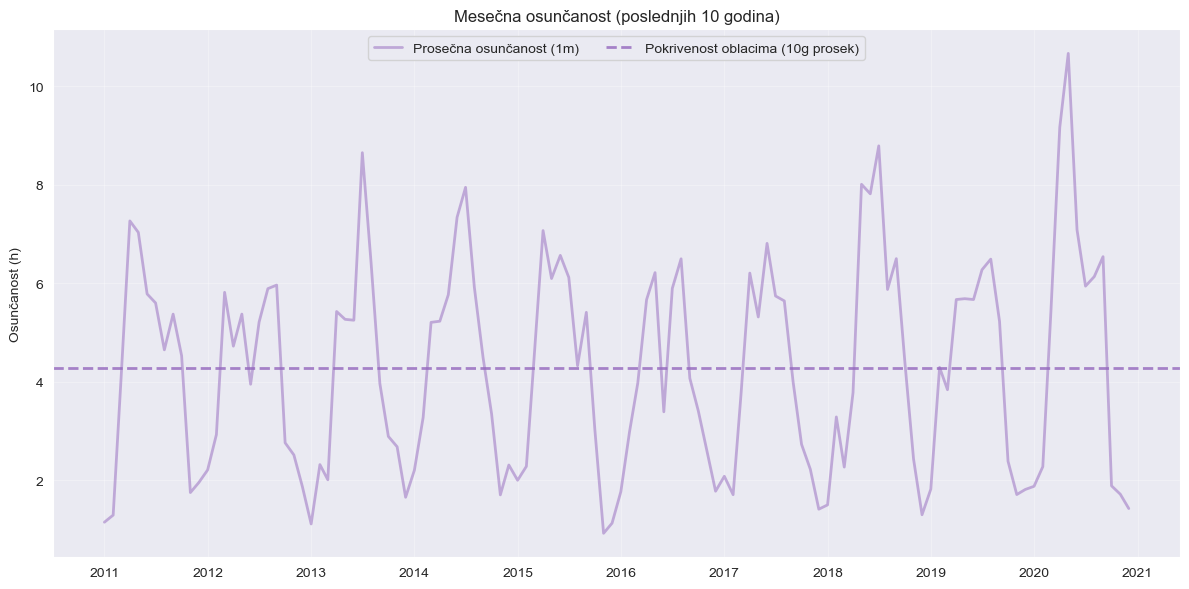

In [16]:
M = df[['sunshine']].resample('MS').mean()

end = M.index.max()
start = (end - pd.DateOffset(years=10)) + pd.DateOffset(months=1)

Mw = M.loc[start:end]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(Mw.index, Mw['sunshine'],  alpha=0.5, lw=2,label='Prosečna osunčanost (1m)', color='tab:purple')

ax.axhline(Mw['sunshine'].mean(),  color='tab:purple',   ls='--', lw=2, alpha=0.8, label='Pokrivenost oblacima (10g prosek)')

ax.set_title('Mesečna osunčanost (poslednjih 10 godina)')
ax.set_xlabel(''); ax.set_ylabel('Osunčanost (h)')

ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.grid(True, alpha=0.3)
ax.legend(ncol=2, loc='upper center')
plt.tight_layout()
plt.show()


In [17]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

def eval_metrics(model,y_true, y_hat):
    mae = mean_absolute_error(y_true, y_hat)
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_hat)
    return pd.DataFrame([{
        "Model": model,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2": r2
    }])

# Linear regression

    Model      MAE      MSE    RMSE       R2
LinearReg 1.109394 2.062901 1.43628 0.675041
   Model      MAE      MSE     RMSE       R2
Naive-12 1.415846 3.227474 1.796517 0.491591


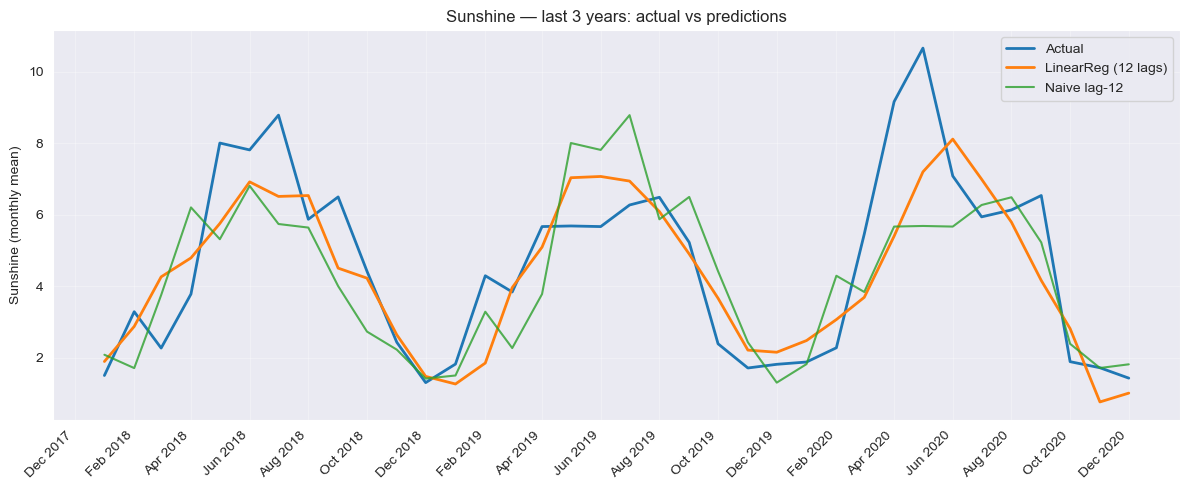

In [18]:
from sklearn.linear_model import LinearRegression

sun = df['sunshine'].resample('MS').mean()

def make_lags(series, lags=12):
    out = pd.DataFrame({'sunshine': series})
    for k in range(1, lags + 1):
        out[f'lag_{k}'] = series.shift(k)
    return out

data = make_lags(sun, lags=12).dropna()

test_start = pd.Timestamp('2018-01-01')
test_end   = df.index.max()

train = data.loc[data.index < test_start]
test  = data.loc[(data.index >= test_start) & (data.index <= test_end)]

X_train = train.drop(columns='sunshine').values
y_train = train['sunshine'].values
X_test  = test.drop(columns='sunshine').values
y_test  = test['sunshine'].values

lin = LinearRegression()
lin.fit(X_train, y_train)
y_pred = lin.predict(X_test)

y_naive = test['lag_12'].values

metrics_lr = eval_metrics("LinearReg",y_test, y_pred)
metrics_nv = eval_metrics("Naive-12",y_test, y_naive)

print(metrics_lr.to_string(index=False))
print(metrics_nv.to_string(index=False))

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(test.index, y_test,  lw=2, label='Actual')
ax.plot(test.index, y_pred, lw=2, label='LinearReg (12 lags)')
ax.plot(test.index, y_naive, lw=1.5, alpha=0.8, label='Naive lag-12')

ax.set_title('Sunshine — last 3 years: actual vs predictions')
ax.set_ylabel('Sunshine (monthly mean)'); ax.set_xlabel('')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# Testiranje modela

### Pomoćne funkcije

In [20]:
def make_windows(X, y, lookback):
    Xs, ys = [], []
    for i in range(len(X) - lookback):
        Xs.append(X[i:i+lookback].values)
        ys.append(y.iloc[i+lookback])
    return np.array(Xs), np.array(ys)

In [21]:
scaller = MinMaxScaler()
df["day_of_year"] = df.index.dayofyear
df["sin_doy"] = np.sin(2 * np.pi * df["day_of_year"] / 365.25)
df["cos_doy"] = np.cos(2 * np.pi * df["day_of_year"] / 365.25)
features = scaller.fit_transform(df.drop(columns=['sunshine','day_of_year']))
features = pd.DataFrame(features, columns=df.drop(columns=['sunshine','day_of_year']).columns)

target = df['sunshine']
features.index=df.index
target.index=df.index

In [50]:
def make_split(X,y,lookback):
    win_index = features.index[lookback:]

    train_end_date = pd.Timestamp("2015-01-01")
    val_end_date   = pd.Timestamp("2018-01-01")

    train_mask = win_index <= train_end_date
    val_mask   = (win_index > train_end_date) & (win_index <= val_end_date)
    test_mask  = win_index > val_end_date

    X_train, y_train = X[train_mask], y[train_mask]
    X_val,   y_val   = X[val_mask],   y[val_mask]
    X_test,  y_test  = X[test_mask],  y[test_mask]
    return X_train,y_train,X_val,y_val,X_test,y_test


def plot_loss(history,title:str="Loss over epochs"):
    train_loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_test(y_test,y_pred,pred_label:str="LSTM"):
    idx = pd.date_range("2018-01-01", periods=1095, freq="D")
    df_pred = pd.DataFrame({
        "Actual": y_test,
        pred_label: y_pred
    }, index=idx)

    df_monthly = df_pred.resample("MS").mean()

    fig, ax = plt.subplots(figsize=(12,5))
    ax.plot(df_monthly.index, df_monthly["Actual"], lw=2, label="Actual (monthly mean)")
    ax.plot(df_monthly.index, df_monthly[pred_label], lw=2, label=f"{pred_label} (monthly mean)")

    ax.set_title("Sunshine — last 3 years")
    ax.set_ylabel("Sunshine"); ax.set_xlabel("")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

def evaluate_model(model_to_eval,test_ds_to_eval,x_test,model_version:str,history):
    test_loss_res, test_rmse_res = model_to_eval.evaluate(test_ds_to_eval,verbose=0)
    print(f"Test loss: {test_loss_res:.5f}\nTest rmse: {test_rmse_res:.5f}")
    y_pred_res = model_to_eval.predict(x_test,verbose=0).ravel()
    metrics_res = eval_metrics(f"{model_version}", y_test, y_pred_res)
    print(metrics_res)
    plot_loss(history,title=f"Loss for {model_version}")
    plot_test(y_test, y_pred_res,pred_label=f"{model_version}")
    return y_pred_res, metrics_res

In [23]:
X, y = make_windows(features, target, 30)
X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y,30)
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test {X_test.shape}, y_test: {y_test.shape}")


X_train: (13120, 30, 10), y_train: (13120,)
X_val: (1096, 30, 10), y_val: (1096,)
X_test (1095, 30, 10), y_test: (1095,)


## LSTM

### Testing window parameter

In [23]:
def createLSTMModel(LOOKBACK:int,showSummary:bool=False):
    X, y = make_windows(features, target, LOOKBACK)

    X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y,LOOKBACK)
    BATCH = 256

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(128).batch(BATCH).prefetch(2)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(2)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH).prefetch(2)

    F = X.shape[-1]
    model = keras.Sequential([
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(16,return_sequences=False),
        keras.layers.Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.losses.MeanSquaredError(),
        metrics=[tf.metrics.RootMeanSquaredError()]
    )
    if showSummary:
        model.summary()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
        ],
        verbose=0
    )
    return model, history, test_ds, X_test, y_test

In [24]:
LOOKBACK_WINDOWS=[3, 7, 14, 30]
MODELS_LSTM = [createLSTMModel(L) for L in LOOKBACK_WINDOWS]

In [25]:
METRICS_LSTM = []
for i,(model,history,test_ds,X_test,y_test) in enumerate(MODELS_LSTM):
    y_prediction_lstm = model.predict(X_test,verbose=0).ravel()
    metrics_lstm = eval_metrics(f"LSTM_{LOOKBACK_WINDOWS[i]}", y_test, y_prediction_lstm)
    METRICS_LSTM.append(metrics_lstm)
df_all = pd.concat(METRICS_LSTM, ignore_index=True)
print(df_all.to_string(index=False))

  Model      MAE       MSE     RMSE       R2
 LSTM_3 2.415940  8.731773 2.954957 0.536331
 LSTM_7 2.369951  8.470582 2.910426 0.550201
LSTM_14 3.093215 14.339530 3.786757 0.238552
LSTM_30 2.467270  9.195663 3.032435 0.511698


Test loss: 14.33953
Test rmse: 3.78676
     Model       MAE        MSE      RMSE        R2
0  LSTM_V1  3.085623  15.670139  3.958553  0.167895


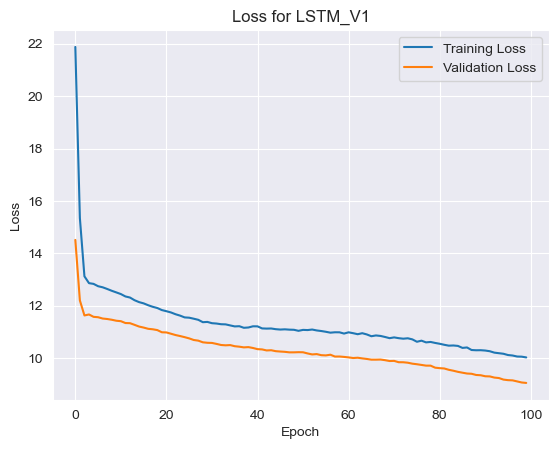

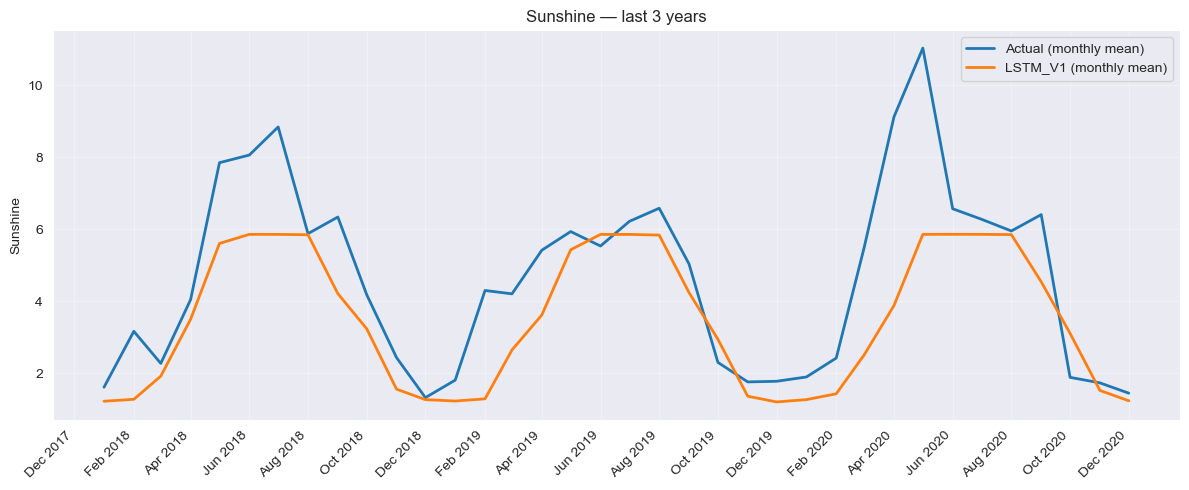

In [26]:
y_pred_lstm_v1, metrics_lstm_v1 = evaluate_model(model_to_eval=MODELS_LSTM[2][0],test_ds_to_eval=MODELS_LSTM[2][2],x_test=X_test,model_version="LSTM_V1")

### Adam Optimizer (lr=1e-4)

In [27]:
LOOKBACK = 14
X, y = make_windows(features, target, LOOKBACK)
X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y, LOOKBACK)

BATCH = 256

# --- Build datasets ---
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(128)
    .batch(BATCH)
    .prefetch(2)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH)
    .prefetch(2)
)
test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(BATCH)
    .prefetch(2)
)

In [28]:
F = X.shape[-1]
model_lstm_v2 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(16, return_sequences=False),
        keras.layers.Dense(1),
    ]
)

model_lstm_v2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_lstm_v2.summary()

history = model_lstm_v2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 14, 32)            5504      
                                                                 
 dropout_4 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_9 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,657
Trainable params: 8,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 - 3s - loss: 32.1858 - root_mean_squared_error: 5.6733 - val_loss: 26.4233 - val_root_mean_squared_error: 5.1404 - lr: 1.0000e-04 - 3s/epoch - 53ms/step
Epoch 2/100
5

Test loss: 14.38873
Test rmse: 3.79325
     Model       MAE        MSE      RMSE        R2
0  LSTM_V2  3.106085  14.388734  3.793248  0.235939


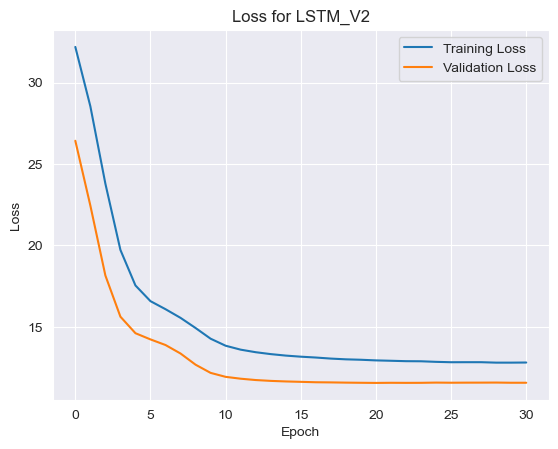

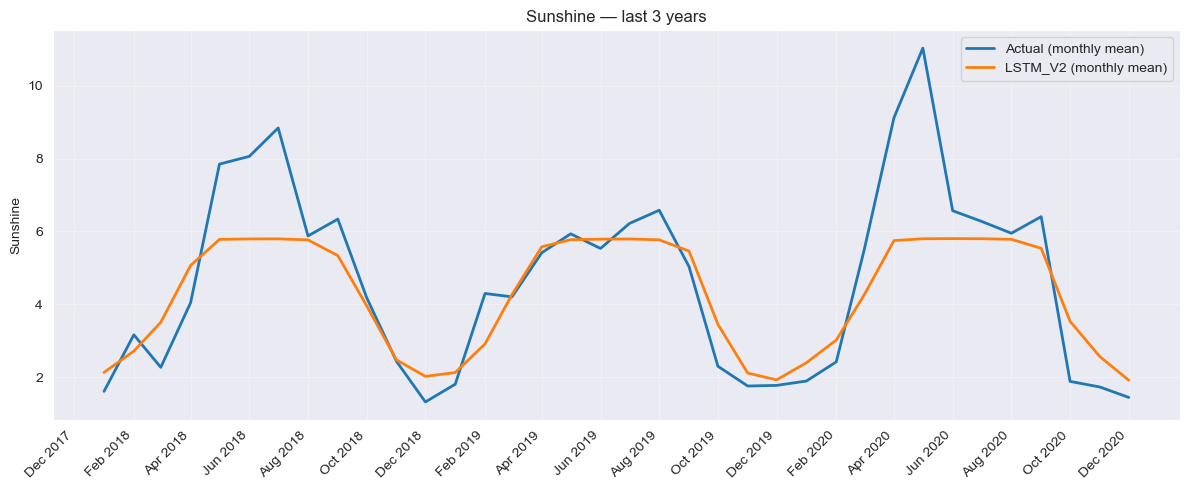

In [29]:
y_pred_lstm_v2, metrics_lstm_v2 = evaluate_model(model_to_eval=model_lstm_v2,test_ds_to_eval=test_ds,x_test=X_test,model_version="LSTM_V2")

### NormalizationLayer

In [30]:
F = X.shape[-1]
model_lstm_v3 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.LayerNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(16, return_sequences=False),
        keras.layers.Dense(1),
    ]
)

model_lstm_v3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_lstm_v3.summary()

# --- Train model ---
history = model_lstm_v3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 14, 32)            5504      
                                                                 
 layer_normalization (LayerN  (None, 14, 32)           64        
 ormalization)                                                   
                                                                 
 dropout_5 (Dropout)         (None, 14, 32)            0         
                                                                 
 lstm_11 (LSTM)              (None, 16)                3136      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,721
Trainable params: 8,721
Non-trainable params: 0
____________________________________________________

Test loss: 8.30339
Test rmse: 2.88156
     Model       MAE       MSE      RMSE        R2
0  LSTM_V3  2.374727  8.303393  2.881561  0.559079


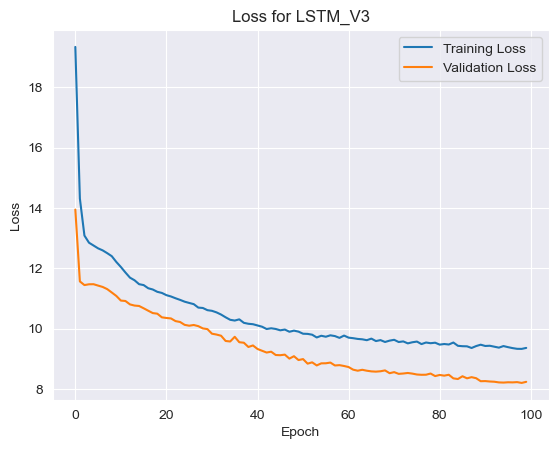

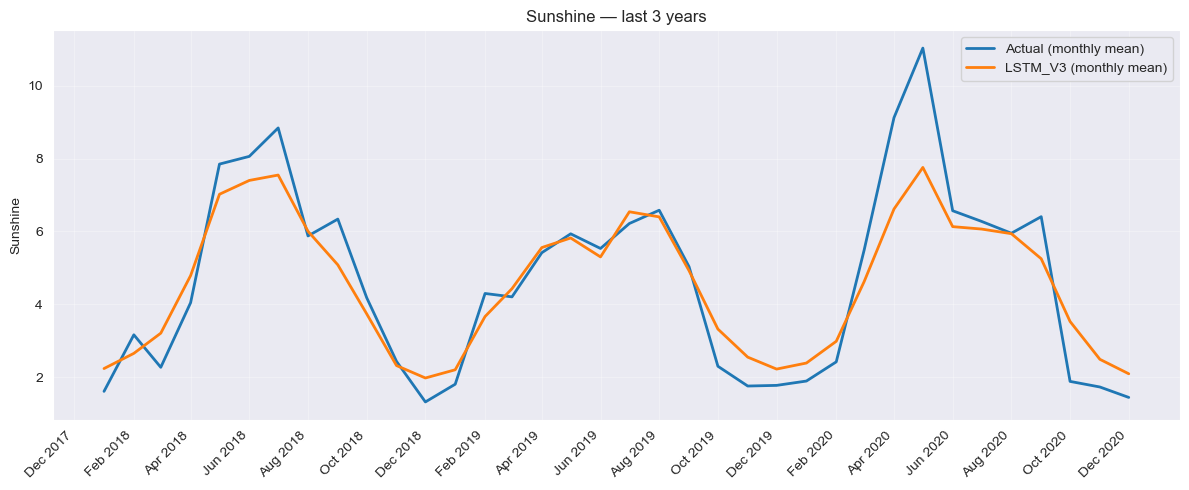

In [31]:
y_pred_lstm_v3, metrics_lstm_v3 = evaluate_model(model_to_eval=model_lstm_v3,test_ds_to_eval=test_ds,x_test=X_test,model_version="LSTM_V3")

### Bidirectional LSTM

In [32]:
F = X.shape[-1]
model_lstm_v4 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
        keras.layers.LayerNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.LSTM(16, return_sequences=False),
        keras.layers.Dense(1),
    ]
)

model_lstm_v4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_lstm_v4.summary()

# --- Train model ---
history = model_lstm_v4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 14, 64)           11008     
 l)                                                              
                                                                 
 layer_normalization_1 (Laye  (None, 14, 64)           128       
 rNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 14, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 16)                5184      
                                                                 
 dense_6 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16,337
Trainable params: 16,337
Non-trai

Test loss: 8.04685
Test rmse: 2.83670
     Model       MAE       MSE      RMSE        R2
0  LSTM_V4  2.342592  8.046853  2.836698  0.572702


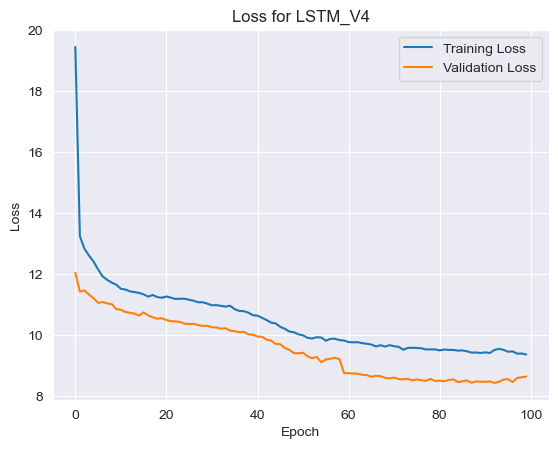

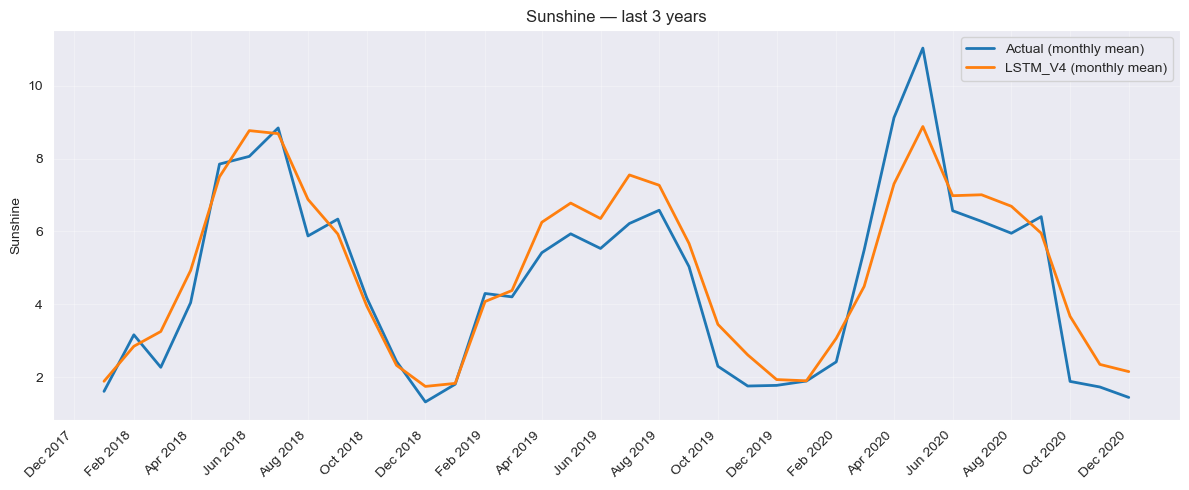

In [33]:
y_pred_lstm_v4, metrics_lstm_v4 = evaluate_model(model_to_eval=model_lstm_v4,test_ds_to_eval=test_ds,x_test=X_test,model_version="LSTM_V4")

### Bidirectional on both LSTM layers

In [34]:
F = X.shape[-1]
model_lstm_v5 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
        keras.layers.LayerNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(keras.layers.LSTM(16, return_sequences=False)),
        keras.layers.Dense(1),
    ]
)

model_lstm_v5.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_lstm_v5.summary()

# --- Train model ---
history = model_lstm_v5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 14, 64)           11008     
 nal)                                                            
                                                                 
 layer_normalization_2 (Laye  (None, 14, 64)           128       
 rNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 14, 64)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                      

Test loss: 8.04920
Test rmse: 2.83711
     Model       MAE       MSE      RMSE        R2
0  LSTM_V5  2.333807  8.049201  2.837111  0.572577


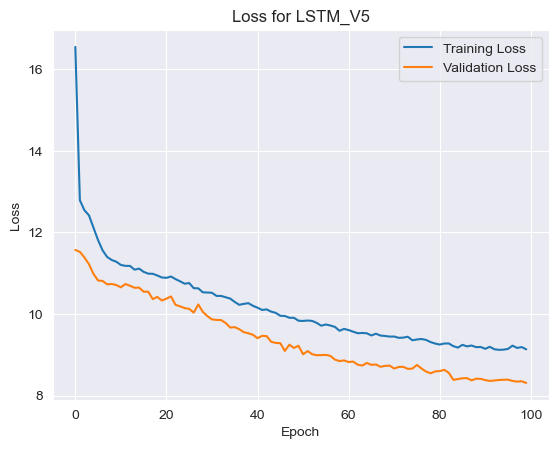

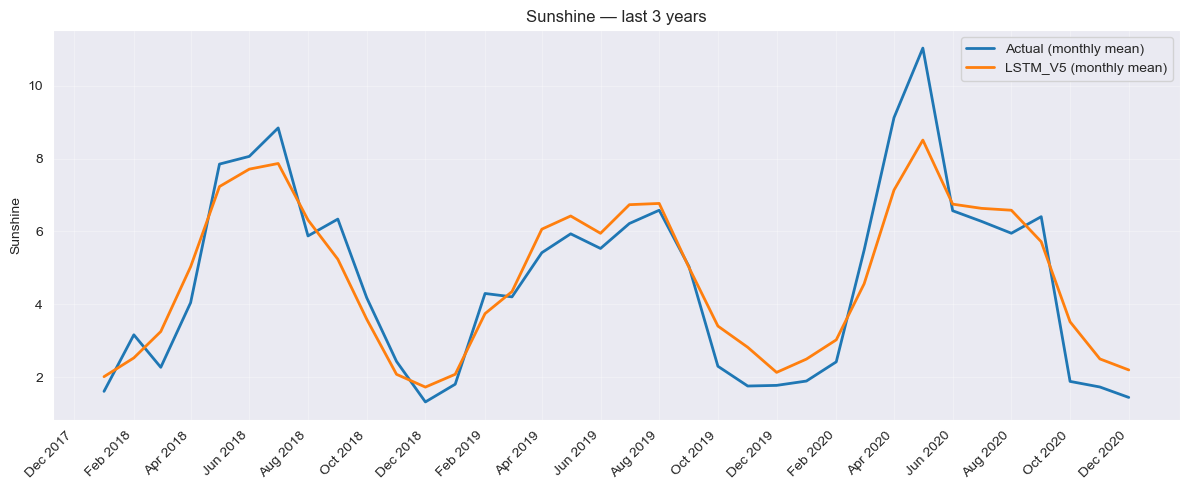

In [35]:
y_pred_lstm_v5, metrics_lstm_v5 = evaluate_model(model_to_eval=model_lstm_v5,test_ds_to_eval=test_ds,x_test=X_test,model_version="LSTM_V5")

### LSTM Comparison

In [36]:
print(pd.concat([metrics_lstm_v1, metrics_lstm_v2, metrics_lstm_v3, metrics_lstm_v4, metrics_lstm_v5], ignore_index=True))

     Model       MAE        MSE      RMSE        R2
0  LSTM_V1  3.085623  15.670139  3.958553  0.167895
1  LSTM_V2  3.106085  14.388734  3.793248  0.235939
2  LSTM_V3  2.374727   8.303393  2.881561  0.559079
3  LSTM_V4  2.342592   8.046853  2.836698  0.572702
4  LSTM_V5  2.333807   8.049201  2.837111  0.572577


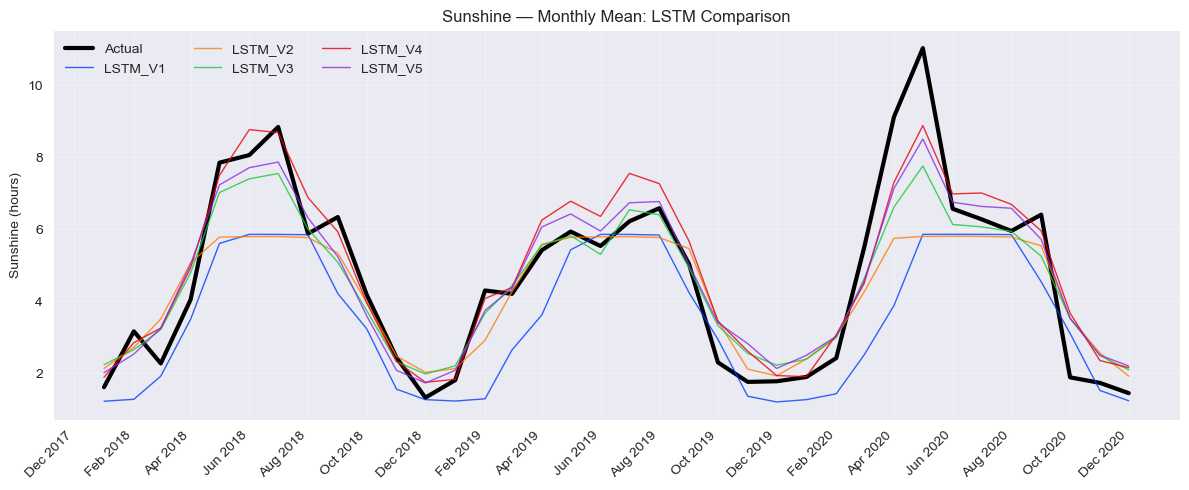

In [37]:
idx = pd.date_range("2018-01-01", periods=len(y_test), freq="D")

df_models = pd.DataFrame({
    "Actual": y_test,
    "LSTM_V1": y_pred_lstm_v1,
    "LSTM_V2": y_pred_lstm_v2,
    "LSTM_V3": y_pred_lstm_v3,
    "LSTM_V4": y_pred_lstm_v4,
    "LSTM_V5": y_pred_lstm_v5
}, index=idx)
colors = seaborn.color_palette("bright", 6)

# Mesečni prosek
df_monthly = df_models.resample("MS").mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_monthly.index, df_monthly["Actual"], lw=3, color="black", label="Actual")

for i, col in enumerate(df_monthly.columns[1:]):
    ax.plot(df_monthly.index, df_monthly[col], lw=1, alpha=0.8, color=colors[i], label=col)

ax.set_title("Sunshine — Monthly Mean: LSTM Comparison")
ax.set_ylabel("Sunshine (hours)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(True, alpha=0.3)
ax.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()

## GRU

### Testing window parameter

In [38]:
def createGRUModel(LOOKBACK:int,showSummary:bool=False):
    X, y = make_windows(features, target, LOOKBACK)

    X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y,LOOKBACK)
    BATCH = 256

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(128).batch(BATCH).prefetch(2)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(2)
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH).prefetch(2)

    F = X.shape[-1]
    model = keras.Sequential([
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.GRU(32, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.GRU(16,return_sequences=False),
        keras.layers.Dense(1)
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.losses.MeanSquaredError(),
        metrics=[tf.metrics.RootMeanSquaredError()]
    )
    if showSummary:
        model.summary()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
        ],
        verbose=0
    )
    return model, history, test_ds, X_test, y_test

In [39]:
LOOKBACK_WINDOWS=[3, 7, 14, 30]
MODELS_GRU = [createGRUModel(L) for L in LOOKBACK_WINDOWS]

In [40]:
METRICS_GRU = []
for i,(model,history,test_ds,X_test,y_test) in enumerate(MODELS_GRU):
    test_loss, test_rmse = model.evaluate(test_ds,verbose=0)
    y_prediction = model.predict(X_test,verbose=0).ravel()
    metrics_lstm = eval_metrics(f"GRU_{LOOKBACK_WINDOWS[i]}", y_test, y_prediction)
    METRICS_GRU.append(metrics_lstm)
df_all = pd.concat(METRICS_GRU, ignore_index=True)
print(df_all.to_string(index=False))

 Model      MAE      MSE     RMSE       R2
 GRU_3 2.338485 8.401952 2.898612 0.553845
 GRU_7 2.334580 7.875099 2.806261 0.581822
GRU_14 2.312338 7.923725 2.814911 0.579240
GRU_30 2.325694 8.349897 2.889619 0.556610


Test loss: 7.92373
Test rmse: 2.81491
    Model       MAE       MSE      RMSE        R2
0  GRU_V1  2.353151  7.978915  2.824697  0.576309


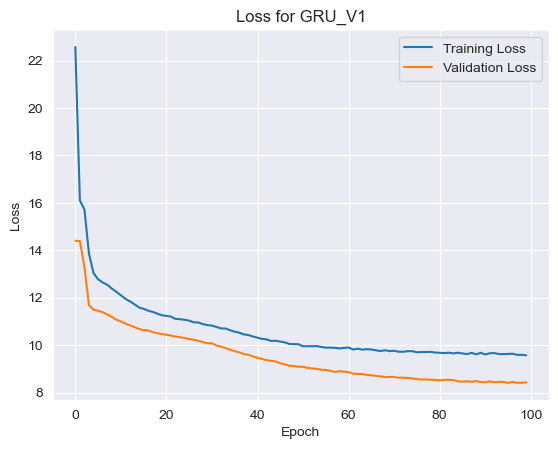

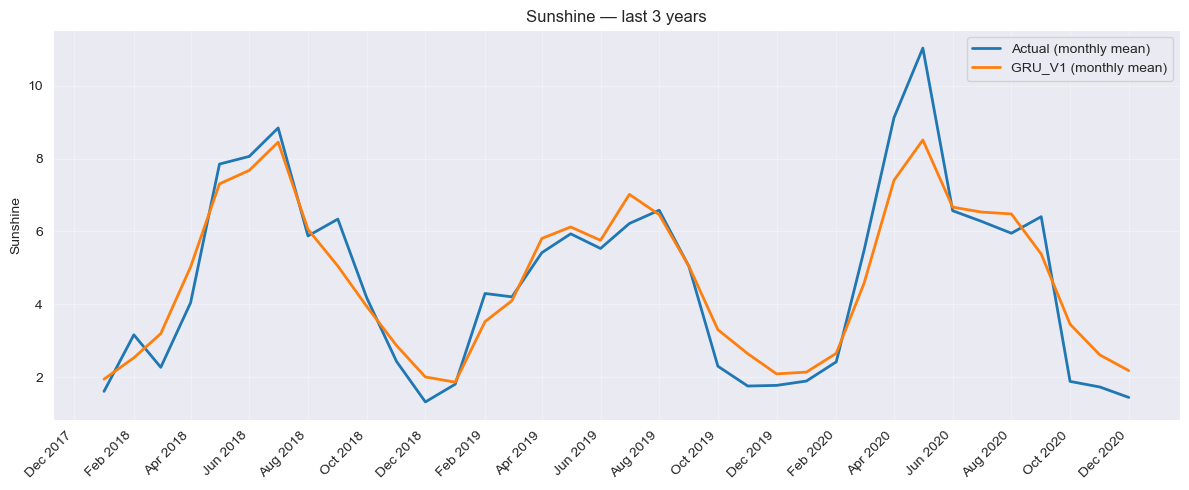

In [41]:
y_pred_gru_v1, metrics_gru_v1 = evaluate_model(model_to_eval=MODELS_GRU[2][0],test_ds_to_eval=MODELS_GRU[2][2],x_test=X_test,model_version="GRU_V1")

### Adam Optimizer (lr=1e-4)

In [42]:
LOOKBACK = 14
X, y = make_windows(features, target, LOOKBACK)
X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y, LOOKBACK)

BATCH = 256

# --- Build datasets ---
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(128)
    .batch(BATCH)
    .prefetch(2)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH)
    .prefetch(2)
)
test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(BATCH)
    .prefetch(2)
)

In [43]:
F = X.shape[-1]
model_gru_v2 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.GRU(32, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.GRU(16, return_sequences=False),
        keras.layers.Dense(1),
    ]
)

model_gru_v2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_gru_v2.summary()

# --- Train model ---
history = model_gru_v2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 14, 32)            4224      
                                                                 
 dropout_12 (Dropout)        (None, 14, 32)            0         
                                                                 
 gru_9 (GRU)                 (None, 16)                2400      
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 - 3s - loss: 35.2280 - root_mean_squared_error: 5.9353 - val_loss: 29.1640 - val_root_mean_squared_error: 5.4004 - lr: 1.0000e-04 - 3s/epoch - 58ms/step
Epoch 2/100


Test loss: 14.12539
Test rmse: 3.75838
    Model       MAE        MSE      RMSE        R2
0  GRU_V2  3.081281  14.125393  3.758376  0.249923


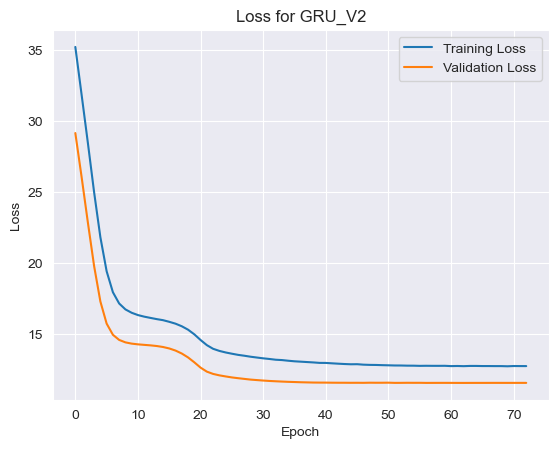

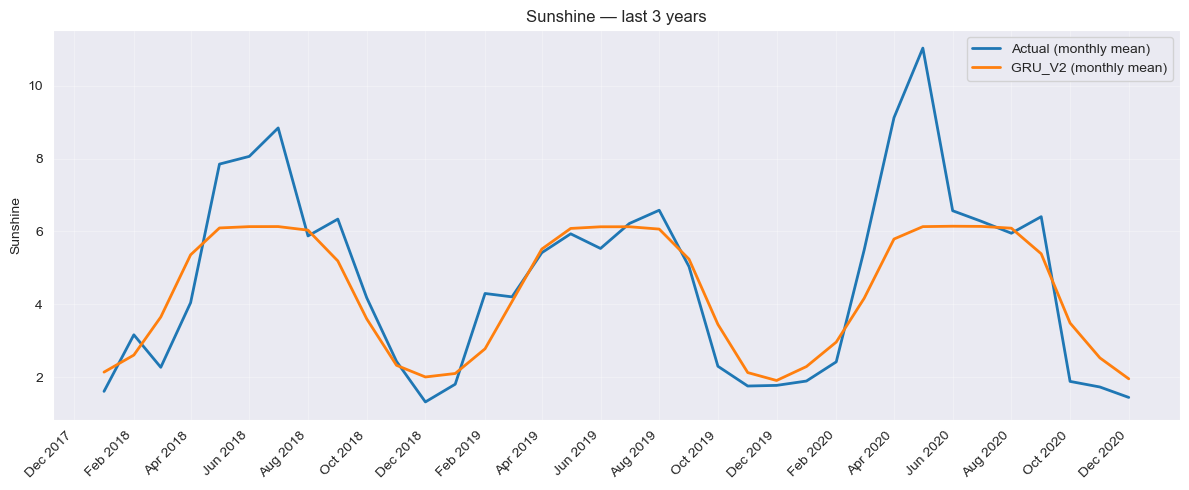

In [44]:
y_pred_gru_v2, metrics_gru_v2 = evaluate_model(model_to_eval=model_gru_v2,test_ds_to_eval=test_ds,x_test=X_test,model_version="GRU_V2")

### Normalization Layer

In [45]:
F = X.shape[-1]
model_gru_v3 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.GRU(32, return_sequences=True),
        keras.layers.LayerNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.GRU(16, return_sequences=False),
        keras.layers.Dense(1),
    ]
)

model_gru_v3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_gru_v3.summary()

# --- Train model ---
history = model_gru_v3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 14, 32)            4224      
                                                                 
 layer_normalization_3 (Laye  (None, 14, 32)           64        
 rNormalization)                                                 
                                                                 
 dropout_13 (Dropout)        (None, 14, 32)            0         
                                                                 
 gru_11 (GRU)                (None, 16)                2400      
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,705
Trainable params: 6,705
Non-trainable params: 0
___________________________________________________

Test loss: 8.03933
Test rmse: 2.83537
    Model       MAE       MSE     RMSE        R2
0  GRU_V3  2.305416  8.039325  2.83537  0.573101


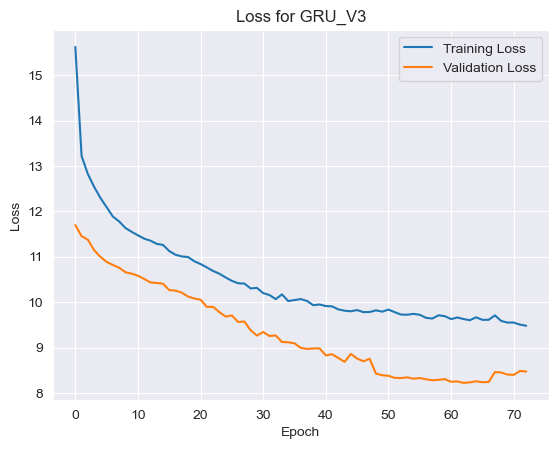

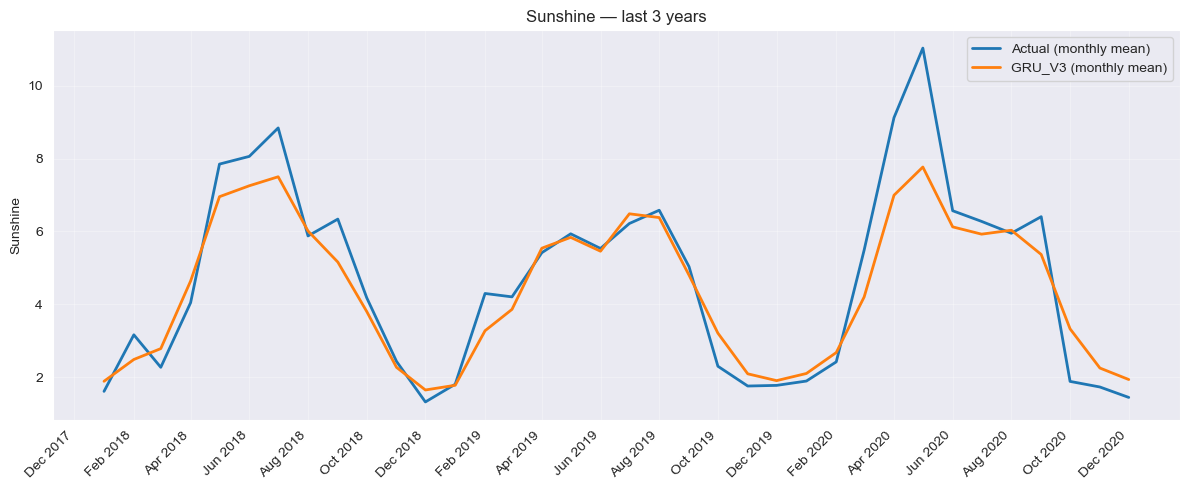

In [46]:
y_pred_gru_v3, metrics_gru_v3 = evaluate_model(model_to_eval=model_gru_v3,test_ds_to_eval=test_ds,x_test=X_test,model_version="GRU_V3")

### Bidirectional GRU

In [47]:
F = X.shape[-1]
model_gru_v4 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.Bidirectional(keras.layers.GRU(32, return_sequences=True)),
        keras.layers.LayerNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.GRU(16, return_sequences=False),
        keras.layers.Dense(1),
    ]
)

model_gru_v4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_gru_v4.summary()

# --- Train model ---
history = model_gru_v4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 14, 64)           8448      
 nal)                                                            
                                                                 
 layer_normalization_4 (Laye  (None, 14, 64)           128       
 rNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 14, 64)            0         
                                                                 
 gru_13 (GRU)                (None, 16)                3936      
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 12,529
Trainable params: 12,529
Non-tra

Test loss: 8.14955
Test rmse: 2.85474
    Model       MAE       MSE      RMSE        R2
0  GRU_V4  2.307416  8.149552  2.854742  0.567248


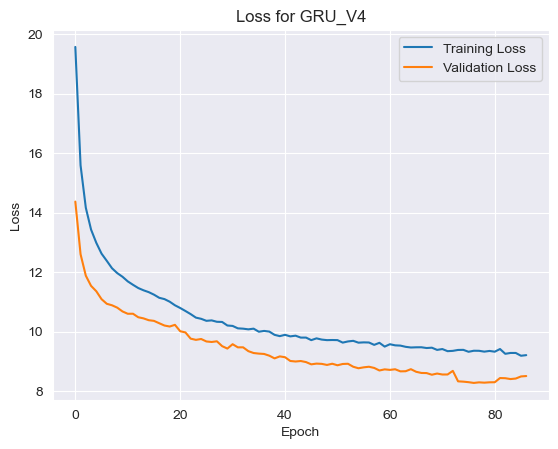

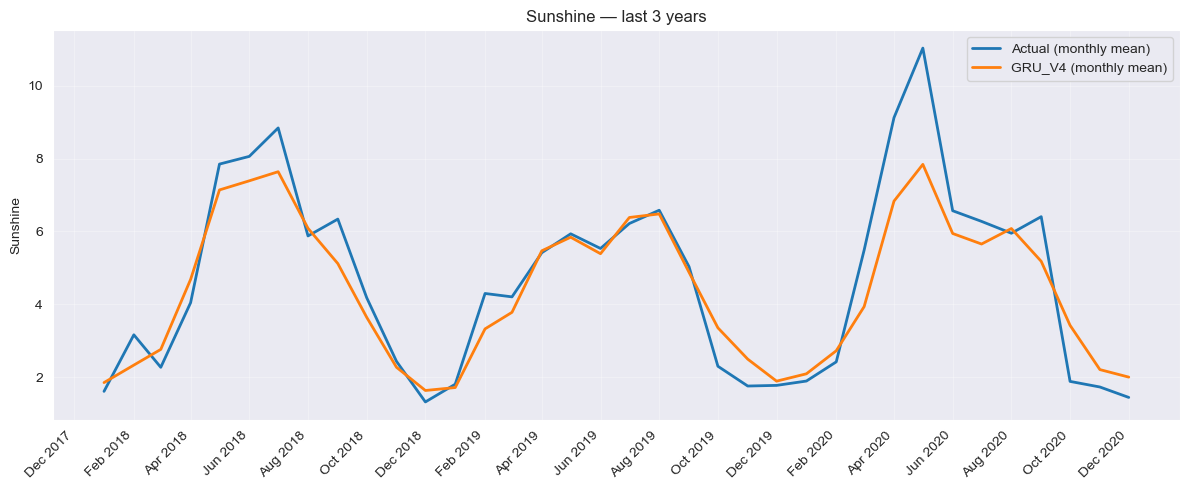

In [48]:
y_pred_gru_v4, metrics_gru_v4 = evaluate_model(model_to_eval=model_gru_v4,test_ds_to_eval=test_ds,x_test=X_test,model_version="GRU_V4")

### Bidirectional on both GRU layers

In [49]:
F = X.shape[-1]
model_gru_v5 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.Bidirectional(keras.layers.GRU(32, return_sequences=True)),
        keras.layers.LayerNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(keras.layers.GRU(16, return_sequences=False)),
        keras.layers.Dense(1),
    ]
)

model_gru_v5.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_gru_v5.summary()

# --- Train model ---
history = model_gru_v5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_4 (Bidirectio  (None, 14, 64)           8448      
 nal)                                                            
                                                                 
 layer_normalization_5 (Laye  (None, 14, 64)           128       
 rNormalization)                                                 
                                                                 
 dropout_15 (Dropout)        (None, 14, 64)            0         
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               7872      
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                     

Test loss: 8.12539
Test rmse: 2.85051
    Model       MAE       MSE      RMSE        R2
0  GRU_V5  2.341022  8.125389  2.850507  0.568531


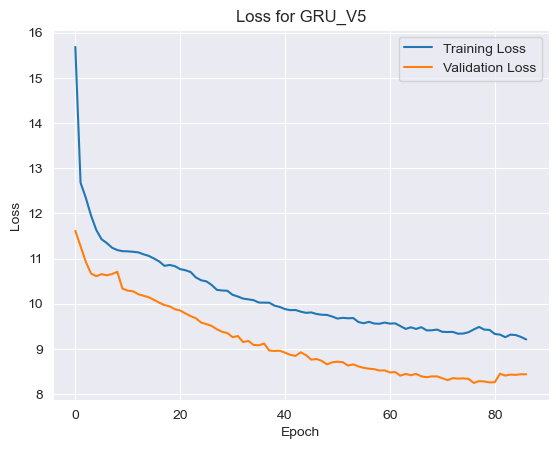

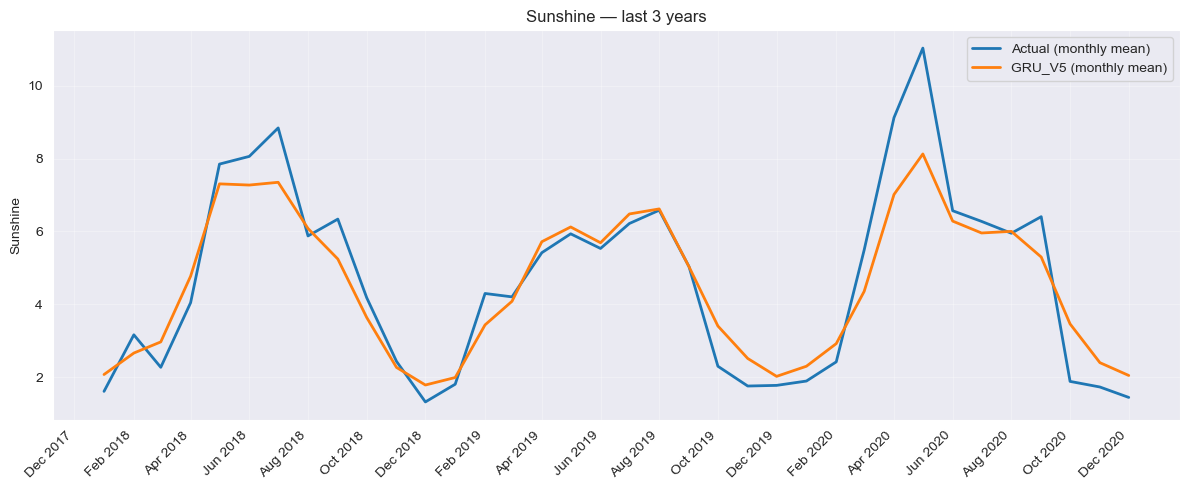

In [50]:
y_pred_gru_v5, metrics_gru_v5 = evaluate_model(model_to_eval=model_gru_v5,test_ds_to_eval=test_ds,x_test=X_test,model_version="GRU_V5")

### GRU Comparison

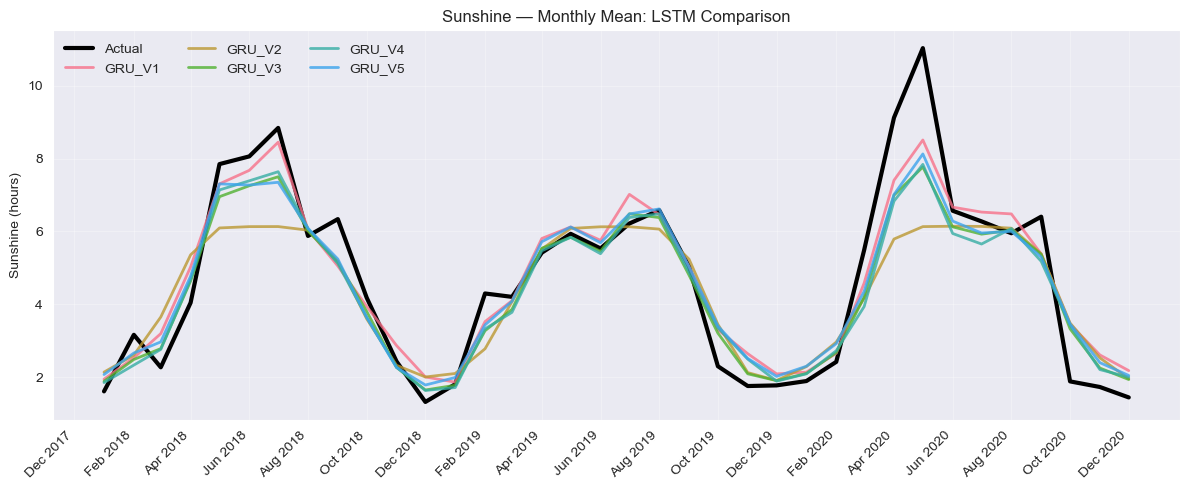

In [51]:
idx = pd.date_range("2018-01-01", periods=len(y_test), freq="D")

df_models = pd.DataFrame({
    "Actual": y_test,
    "GRU_V1": y_pred_gru_v1,
    "GRU_V2": y_pred_gru_v2,
    "GRU_V3": y_pred_gru_v3,
    "GRU_V4": y_pred_gru_v4,
    "GRU_V5": y_pred_gru_v5
}, index=idx)
colors = seaborn.color_palette("husl", 6)

df_monthly = df_models.resample("MS").mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_monthly.index, df_monthly["Actual"], lw=3, color="black", label="Actual")

for i, col in enumerate(df_monthly.columns[1:]):
    ax.plot(df_monthly.index, df_monthly[col], lw=2, alpha=0.8, color=colors[i], label=col)

ax.set_title("Sunshine — Monthly Mean: GRU Comparison")
ax.set_ylabel("Sunshine (hours)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(True, alpha=0.3)
ax.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()

In [52]:
print(pd.concat([metrics_gru_v1, metrics_gru_v2, metrics_gru_v3, metrics_gru_v4, metrics_gru_v5], ignore_index=True))

    Model       MAE        MSE      RMSE        R2
0  GRU_V1  2.353151   7.978915  2.824697  0.576309
1  GRU_V2  3.081281  14.125393  3.758376  0.249923
2  GRU_V3  2.305416   8.039325  2.835370  0.573101
3  GRU_V4  2.307416   8.149552  2.854742  0.567248
4  GRU_V5  2.341022   8.125389  2.850507  0.568531


## Simple RNN

### Initial model

In [55]:
LOOKBACK = 14
X, y = make_windows(features, target, LOOKBACK)
X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y, LOOKBACK)

BATCH = 256

# --- Build datasets ---
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(128)
    .batch(BATCH)
    .prefetch(2)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH)
    .prefetch(2)
)
test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(BATCH)
    .prefetch(2)
)

In [56]:
F = X.shape[-1]
model_rnn_v1 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.SimpleRNN(32, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.SimpleRNN(16, return_sequences=False),
        keras.layers.Dense(1),
    ]
)

model_rnn_v1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_rnn_v1.summary()

# --- Train model ---
history = model_rnn_v1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 14, 32)            1376      
                                                                 
 dropout_16 (Dropout)        (None, 14, 32)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 - 3s - loss: 24.1136 - root_mean_squared_error: 4.9106 - val_loss: 14.6318 - val_root_mean_squared_error: 3.8251 - lr: 0.0010 - 3s/epoch - 59ms/step
Epoch 2/100
52/5

Test loss: 8.17240
Test rmse: 2.85874
    Model       MAE       MSE      RMSE        R2
0  RNN_V1  2.344089  8.172403  2.858741  0.566035


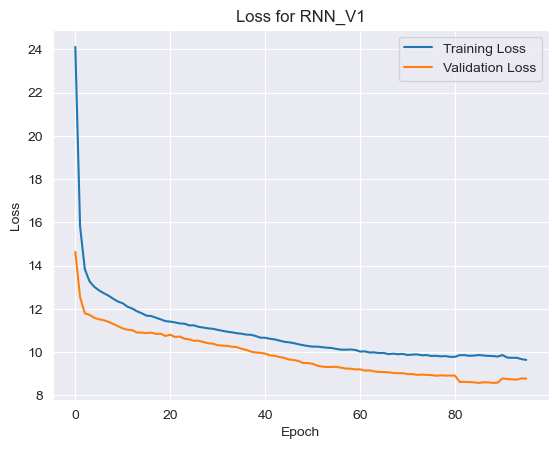

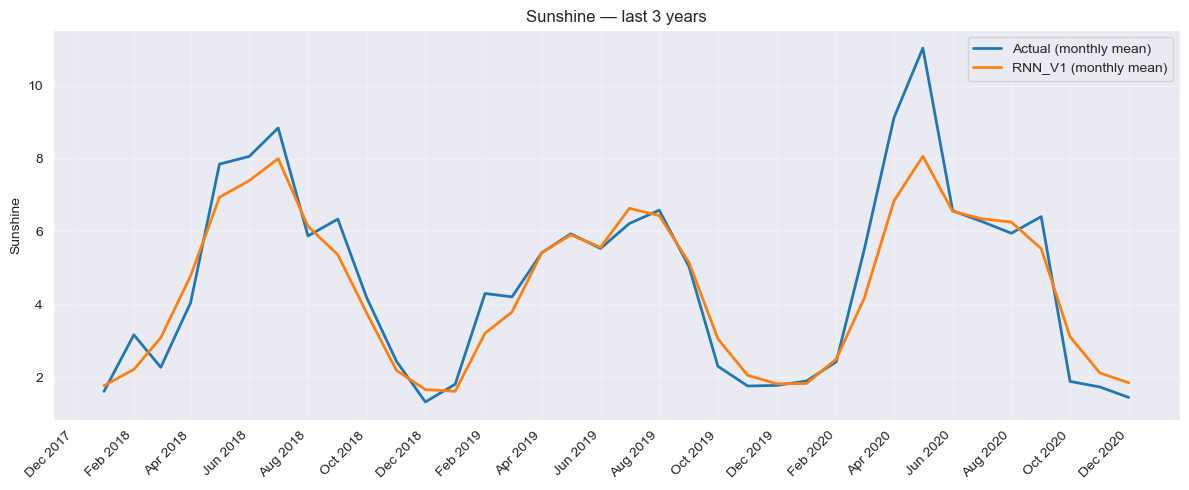

In [57]:
y_pred_rnn_v1, metrics_rnn_v1 = evaluate_model(model_to_eval=model_rnn_v1,test_ds_to_eval=test_ds,x_test=X_test,model_version="RNN_V1")

### Adam Optimizer (le=1e-4)

In [59]:
F = X.shape[-1]
model_rnn_v2 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.SimpleRNN(32, return_sequences=True),
        keras.layers.Dropout(0.2),
        keras.layers.SimpleRNN(16, return_sequences=False),
        keras.layers.Dense(1),
    ]
)

model_rnn_v2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_rnn_v2.summary()

# --- Train model ---
history = model_rnn_v2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 14, 32)            1376      
                                                                 
 dropout_17 (Dropout)        (None, 14, 32)            0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,177
Trainable params: 2,177
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 - 6s - loss: 38.5352 - root_mean_squared_error: 6.2077 - val_loss: 24.8384 - val_root_mean_squared_error: 4.9838 - lr: 1.0000e-04 - 6s/epoch - 113ms/step
Epoch 2/100

Test loss: 12.53402
Test rmse: 3.54034
    Model      MAE        MSE      RMSE        R2
0  RNN_V2  2.92256  12.534018  3.540341  0.334427


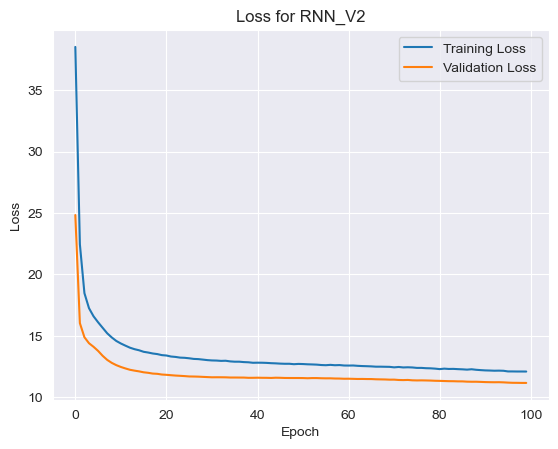

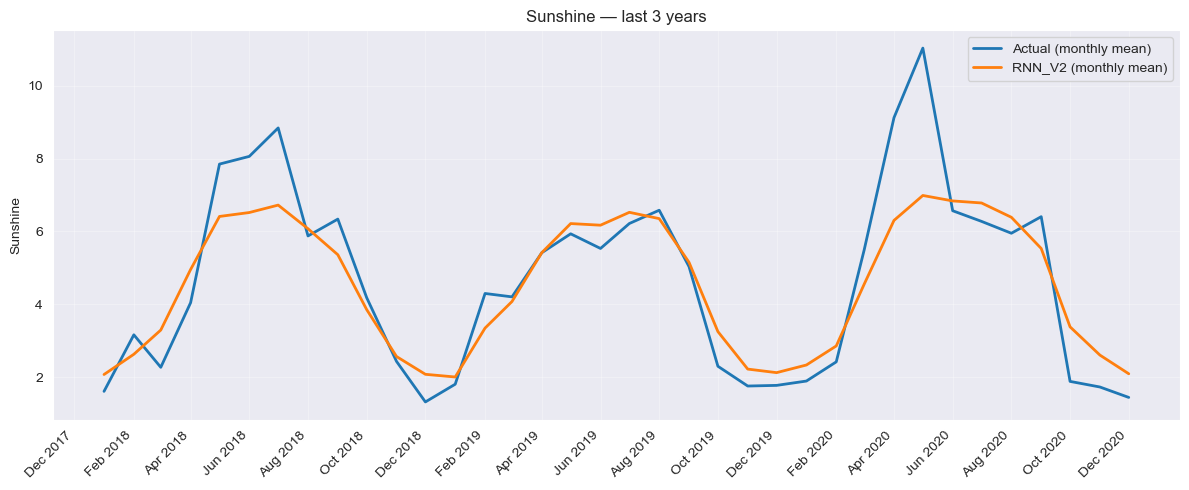

In [60]:
y_pred_rnn_v2, metrics_rnn_v2 = evaluate_model(model_to_eval=model_rnn_v2,test_ds_to_eval=test_ds,x_test=X_test,model_version="RNN_V2")

### Normalization Layer

In [61]:
F = X.shape[-1]
model_rnn_v3 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.SimpleRNN(32, return_sequences=True),
        keras.layers.LayerNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.SimpleRNN(16, return_sequences=False),
        keras.layers.Dense(1),
    ]
)

model_rnn_v3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_rnn_v3.summary()

# --- Train model ---
history = model_rnn_v3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 14, 32)            1376      
                                                                 
 layer_normalization_6 (Laye  (None, 14, 32)           64        
 rNormalization)                                                 
                                                                 
 dropout_18 (Dropout)        (None, 14, 32)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                                 
Total params: 2,241
Trainable params: 2,241
Non-trainable params: 0
___________________________________________________

Test loss: 8.45599
Test rmse: 2.90792
    Model      MAE       MSE      RMSE        R2
0  RNN_V3  2.37368  8.455991  2.907919  0.550976


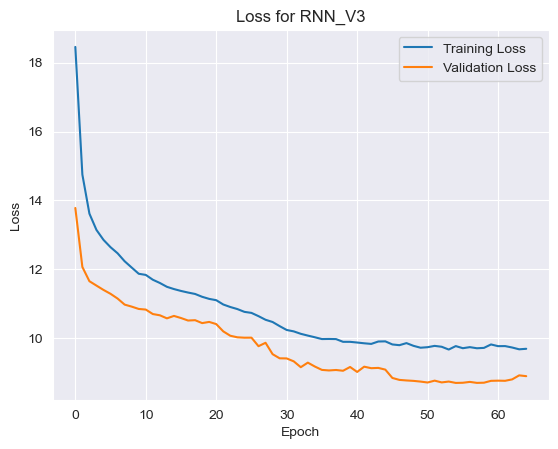

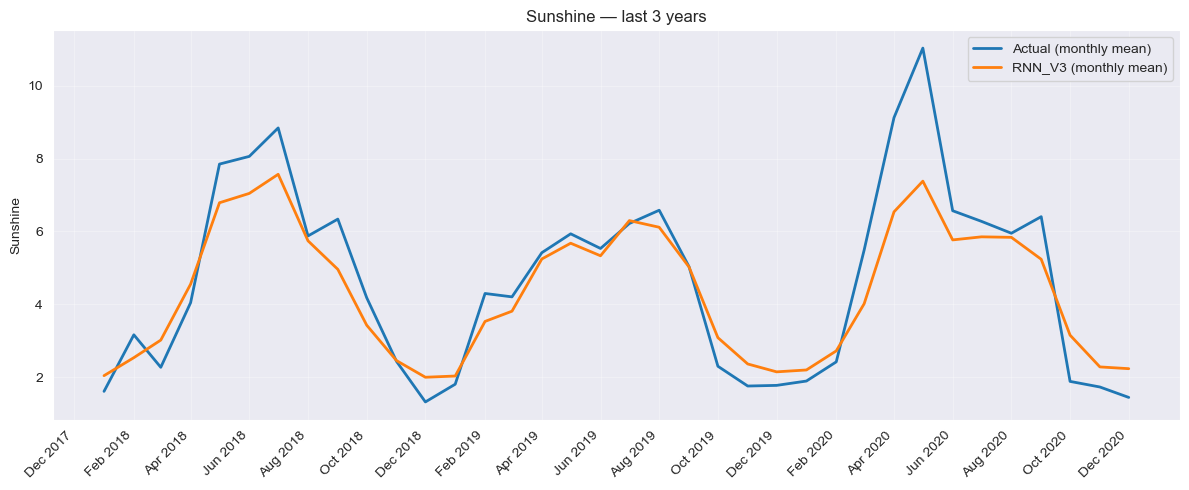

In [62]:
y_pred_rnn_v3, metrics_rnn_v3 = evaluate_model(model_to_eval=model_rnn_v3,test_ds_to_eval=test_ds,x_test=X_test,model_version="RNN_V3")

### Bidirectional Simple RNN

In [ ]:
F = X.shape[-1]
model_rnn_v4 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
        keras.layers.LayerNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.SimpleRNN(16, return_sequences=False),
        keras.layers.Dense(1),
    ]
)

model_rnn_v4.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_rnn_v4.summary()

# --- Train model ---
history = model_rnn_v4.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 14, 64)           2752      
 nal)                                                            
                                                                 
 layer_normalization_7 (Laye  (None, 14, 64)           128       
 rNormalization)                                                 
                                                                 
 dropout_19 (Dropout)        (None, 14, 64)            0         
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 16)                1296      
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 4,193
Trainable params: 4,193
Non-train

In [ ]:
y_pred_rnn_v4, metrics_rnn_v4 = evaluate_model(model_to_eval=model_rnn_v4,test_ds_to_eval=test_ds,x_test=X_test,model_version="RNN_V4")

### Bidirectional on both Simple RNN layers

In [ ]:
F = X.shape[-1]
model_rnn_v5 = keras.Sequential(
    [
        keras.layers.Input(shape=(LOOKBACK, F)),
        keras.layers.Bidirectional(keras.layers.SimpleRNN(32, return_sequences=True)),
        keras.layers.LayerNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(keras.layers.SimpleRNN(16, return_sequences=False)),
        keras.layers.Dense(1),
    ]
)

model_rnn_v5.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()],
)

model_rnn_v5.summary()

# --- Train model ---
history = model_rnn_v5.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5
        ),
    ],
    verbose=2,
)


In [ ]:
y_pred_rnn_v5, metrics_rnn_v5 = evaluate_model(model_to_eval=model_rnn_v5,test_ds_to_eval=test_ds,x_test=X_test,model_version="RNN_V5")

### Simple RNN Comparison

In [ ]:
idx = pd.date_range("2018-01-01", periods=len(y_test), freq="D")

df_models = pd.DataFrame({
    "Actual": y_test,
    "RNN_V1": y_pred_rnn_v1,
    "RNN_V2": y_pred_rnn_v2,
    "RNN_V3": y_pred_rnn_v3,
    "RNN_V4": y_pred_rnn_v4,
    "RNN_V5": y_pred_rnn_v5
}, index=idx)
colors = seaborn.color_palette("husl", 6)

df_monthly = df_models.resample("MS").mean()

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_monthly.index, df_monthly["Actual"], lw=3, color="black", label="Actual")

for i, col in enumerate(df_monthly.columns[1:]):
    ax.plot(df_monthly.index, df_monthly[col], lw=2, alpha=0.8, color=colors[i], label=col)

ax.set_title("Sunshine — Monthly Mean: RNN Comparison")
ax.set_ylabel("Sunshine (hours)")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(True, alpha=0.3)
ax.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()

In [ ]:
print(pd.concat([metrics_rnn_v1, metrics_rnn_v2, metrics_rnn_v3, metrics_rnn_v4, metrics_rnn_v5], ignore_index=True))

## LSTM VS RNN VS GRU Comparison

In [58]:
print(pd.concat([metrics_lstm_v1, metrics_lstm_v2, metrics_lstm_v3, metrics_lstm_v4, metrics_lstm_v5,
        metrics_gru_v1, metrics_gru_v2, metrics_gru_v3, metrics_gru_v4, metrics_gru_v5,
        metrics_rnn_v1, metrics_rnn_v2, metrics_rnn_v3, metrics_rnn_v4, metrics_rnn_v5], ignore_index=True).sort_values(by="R2",ascending=False))

      Model       MAE        MSE      RMSE        R2
5    GRU_V1  2.353151   7.978915  2.824697  0.576309
7    GRU_V3  2.305416   8.039325  2.835370  0.573101
3   LSTM_V4  2.342592   8.046853  2.836698  0.572702
4   LSTM_V5  2.333807   8.049201  2.837111  0.572577
9    GRU_V5  2.341022   8.125389  2.850507  0.568531
8    GRU_V4  2.307416   8.149552  2.854742  0.567248
10   RNN_V1  2.344089   8.172403  2.858741  0.566035
2   LSTM_V3  2.374727   8.303393  2.881561  0.559079
6    GRU_V2  3.081281  14.125393  3.758376  0.249923
1   LSTM_V2  3.106085  14.388734  3.793248  0.235939
0   LSTM_V1  3.085623  15.670139  3.958553  0.167895


## Optimizers

### Pomoćne funkcije

In [48]:
def testOptimizerLSTM(optimizer=keras.optimizers.Adam(learning_rate=1e-3),model_name="lstm"):
    F = X.shape[-1]
    model_lstm = keras.Sequential(
        [
            keras.layers.Input(shape=(LOOKBACK, F)),
            keras.layers.Bidirectional(keras.layers.LSTM(32, return_sequences=True)),
            keras.layers.LayerNormalization(),
            keras.layers.Dropout(0.2),
            keras.layers.LSTM(16, return_sequences=False),
            keras.layers.Dense(1),
        ]
    )

    model_lstm.compile(
        optimizer=optimizer,
        loss=tf.losses.MeanSquaredError(),
        metrics=[tf.metrics.RootMeanSquaredError()],
    )

    model_lstm.summary()

    history_lstm = model_lstm.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5),
        ],
        verbose=2,
    )
    model_lstm.save(f'./trained_models/{model_name}.h5')
    return model_lstm, history_lstm

def testOptimizerGRU(optimizer=keras.optimizers.Adam(learning_rate=1e-3),model_name="gru"):
    F = X.shape[-1]
    model_gru = keras.Sequential(
        [
            keras.layers.Input(shape=(LOOKBACK, F)),
            keras.layers.GRU(32, return_sequences=True),
            keras.layers.Dropout(0.2),
            keras.layers.GRU(16, return_sequences=False),
            keras.layers.Dense(1),
        ]
    )

    model_gru.compile(
        optimizer=optimizer,
        loss=tf.losses.MeanSquaredError(),
        metrics=[tf.metrics.RootMeanSquaredError()],
    )

    model_gru.summary()

    history_gru = model_gru.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5),
        ],
        verbose=2,
    )
    model_gru.save(f'./trained_models/{model_name}.h5')
    return model_gru

def get_history(some_model):
    return some_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5),
        ],
        verbose=0,
    )


### Adamax

In [45]:
LOOKBACK = 14
X, y = make_windows(features, target, LOOKBACK)
X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y, LOOKBACK)

BATCH = 256

# --- Build datasets ---
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .shuffle(128)
    .batch(BATCH)
    .prefetch(2)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH)
    .prefetch(2)
)
test_ds = (
    tf.data.Dataset.from_tensor_slices((X_test, y_test))
    .batch(BATCH)
    .prefetch(2)
)

#### LSTM

In [31]:
model_lstm_v4_adamax = testOptimizerLSTM(keras.optimizers.Adamax(learning_rate=1e-3),model_name="model_lstm_v4_adamax")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 14, 64)           11008     
 nal)                                                            
                                                                 
 layer_normalization_2 (Laye  (None, 14, 64)           128       
 rNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 14, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 16)                5184      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 16,337
Trainable params: 16,337
Non-trai

Test loss: 9.19601
Test rmse: 3.03249
            Model       MAE       MSE      RMSE       R2
0  LSTM_V4_ADAMAX  2.475331  9.196007  3.032492  0.51168


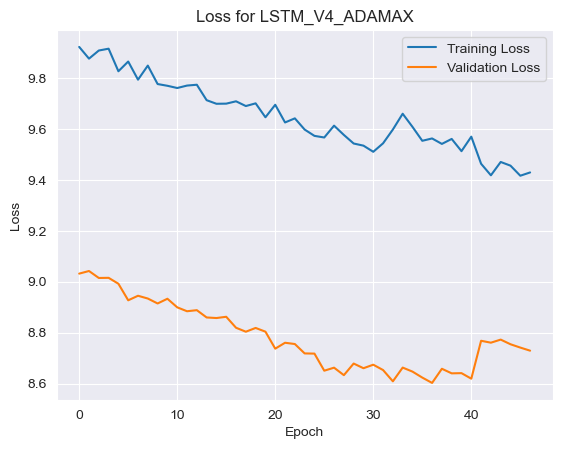

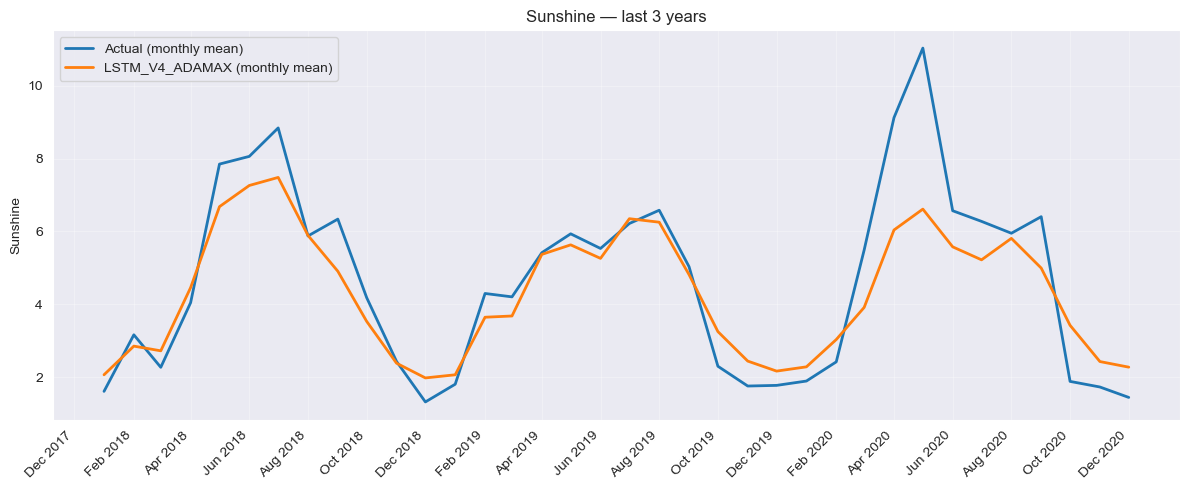

In [51]:
y_pred_lstm_v4_adamax, metrics_lstm_v4_adamax = evaluate_model(model_to_eval=model_lstm_v4_adamax,test_ds_to_eval=test_ds,x_test=X_test,model_version="LSTM_V4_ADAMAX",history=get_history(keras.models.load_model("./trained_models/model_lstm_v4_adamax.h5")))

#### GRU

In [52]:
model_gru_v1_adamax = testOptimizerGRU(keras.optimizers.Adamax(learning_rate=1e-3),model_name="model_gru_v1_adamax")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 32)            4224      
                                                                 
 dropout_3 (Dropout)         (None, 14, 32)            0         
                                                                 
 gru_1 (GRU)                 (None, 16)                2400      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 - 3s - loss: 20.8353 - root_mean_squared_error: 4.5646 - val_loss: 14.2904 - val_root_mean_squared_error: 3.7803 - lr: 0.0010 - 3s/epoch - 59ms/step
Epoch 2/100
52/52

Test loss: 8.79848
Test rmse: 2.96622
           Model       MAE       MSE      RMSE        R2
0  GRU_V1_ADAMAX  2.449684  8.798483  2.966224  0.532789


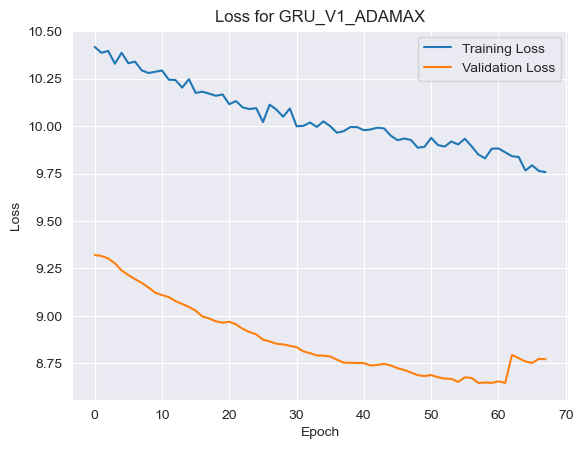

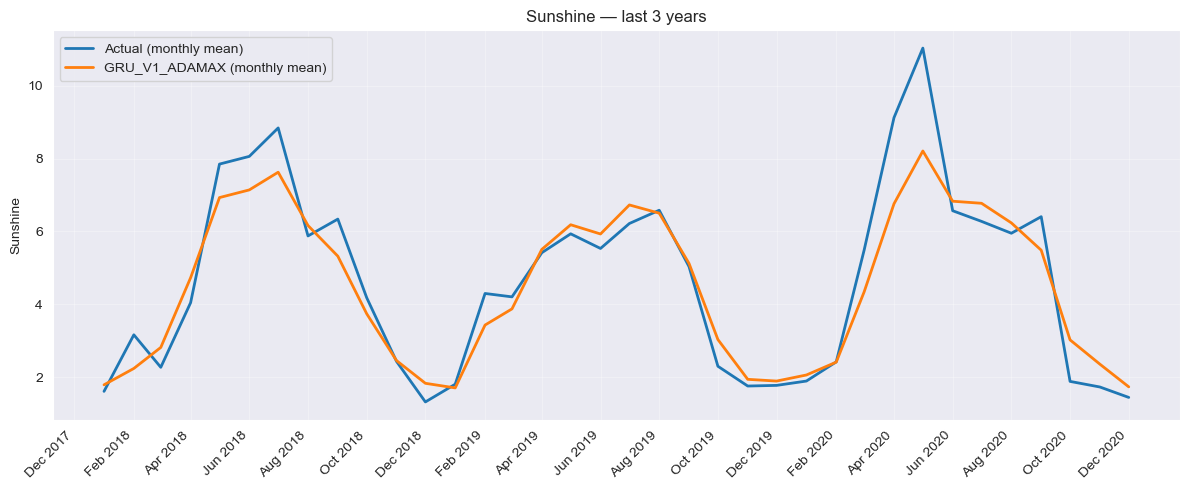

In [53]:
y_pred_gru_v1_adamax, metrics_gru_v1_adamax = evaluate_model(model_to_eval=model_gru_v1_adamax,test_ds_to_eval=test_ds,x_test=X_test,model_version="GRU_V1_ADAMAX",history=get_history(keras.models.load_model("./trained_models/model_gru_v1_adamax.h5")))

### NADAM

#### LSTM

In [46]:
model_lstm_v4_nadam = testOptimizerLSTM(keras.optimizers.Nadam(learning_rate=1e-3),model_name="model_lstm_v4_nadam")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_5 (Bidirectio  (None, 14, 64)           11008     
 nal)                                                            
                                                                 
 layer_normalization_5 (Laye  (None, 14, 64)           128       
 rNormalization)                                                 
                                                                 
 dropout_10 (Dropout)        (None, 14, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 16)                5184      
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16,337
Trainable params: 16,337
Non-tra

Test loss: 8.96179
Test rmse: 2.99363
           Model       MAE       MSE      RMSE        R2
0  LSTM_V4_NADAM  2.464842  8.961794  2.993626  0.524117


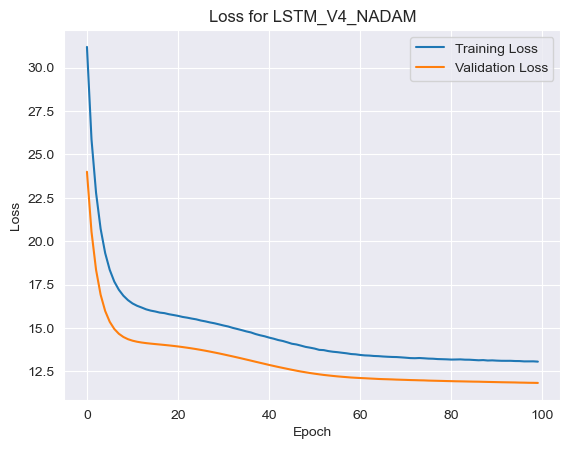

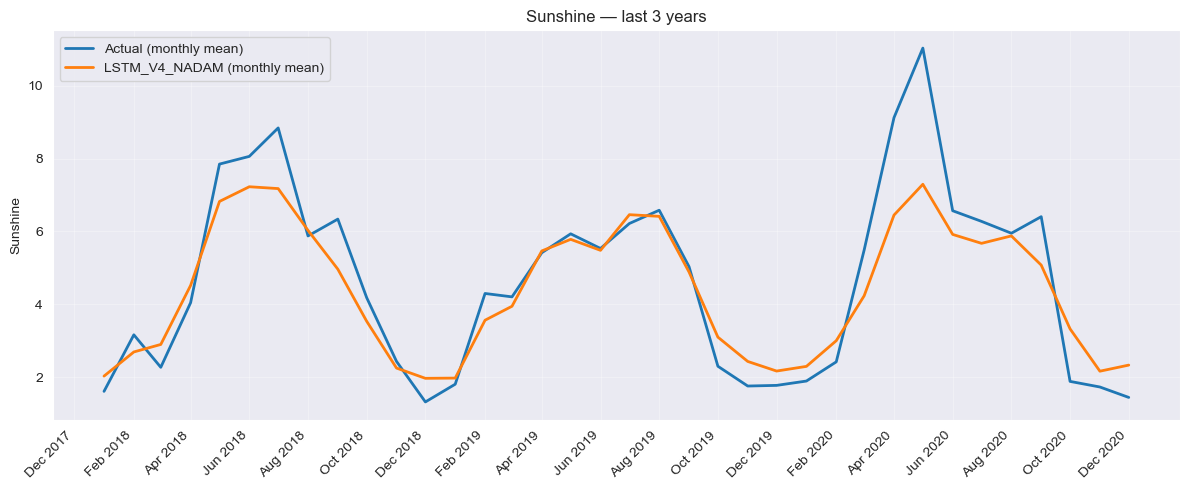

In [47]:
y_pred_lstm_v4_nadam, metrics_lstm_v4_nadam = evaluate_model(model_to_eval=model_lstm_v4_nadam,test_ds_to_eval=test_ds,x_test=X_test,model_version="LSTM_V4_NADAM",history=get_history(keras.models.load_model("./trained_models/model_lstm_v4_nadam.h5")))

#### GRU

In [48]:
model_gru_v1_nadam = testOptimizerGRU(keras.optimizers.Nadam(learning_rate=1e-3),model_name="model_gru_v1_nadam")

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 14, 32)            4224      
                                                                 
 dropout_11 (Dropout)        (None, 14, 32)            0         
                                                                 
 gru_11 (GRU)                (None, 16)                2400      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 - 5s - loss: 22.1530 - root_mean_squared_error: 4.7067 - val_loss: 14.6473 - val_root_mean_squared_error: 3.8272 - lr: 0.0010 - 5s/epoch - 97ms/step
Epoch 2/100
52/5

Test loss: 9.29463
Test rmse: 3.04871
          Model     MAE       MSE     RMSE        R2
0  GRU_V1_NADAM  2.5173  9.294634  3.04871  0.506443


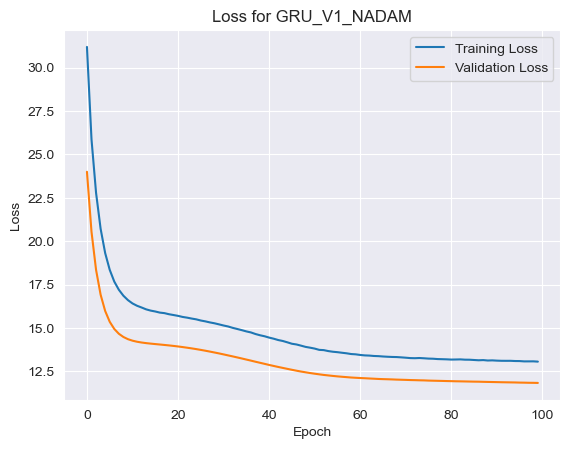

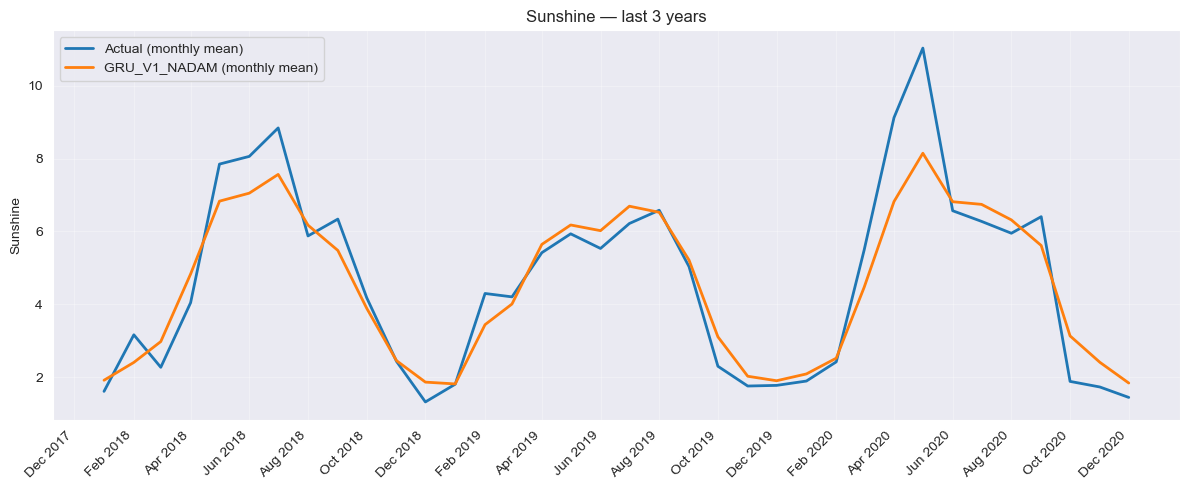

In [49]:
y_pred_gru_v1_nadam, metrics_gru_v1_nadam = evaluate_model(model_to_eval=model_gru_v1_nadam,test_ds_to_eval=test_ds,x_test=X_test,model_version="GRU_V1_NADAM")

### SGD

#### LSTM

In [56]:
model_lstm_v4_sgd = testOptimizerLSTM(keras.optimizers.SGD(learning_rate=1e-3),model_name="model_lstm_v4_sgd")

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 14, 64)           11008     
 nal)                                                            
                                                                 
 layer_normalization_6 (Laye  (None, 14, 64)           128       
 rNormalization)                                                 
                                                                 
 dropout_12 (Dropout)        (None, 14, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 16)                5184      
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16,337
Trainable params: 16,337
Non-tra

Test loss: 9.72500
Test rmse: 3.11849
         Model       MAE       MSE      RMSE       R2
0  LSTM_V4_SGD  2.559108  9.725001  3.118493  0.48359


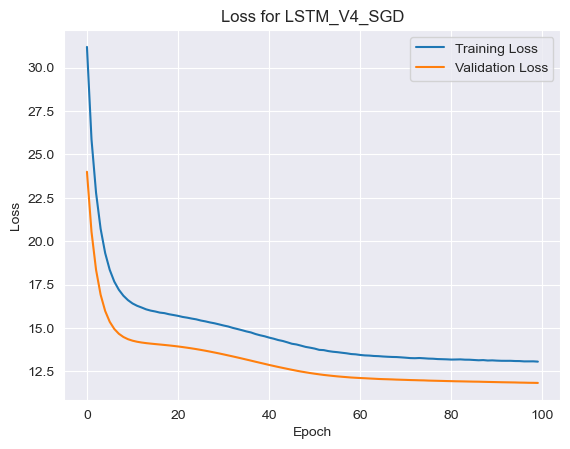

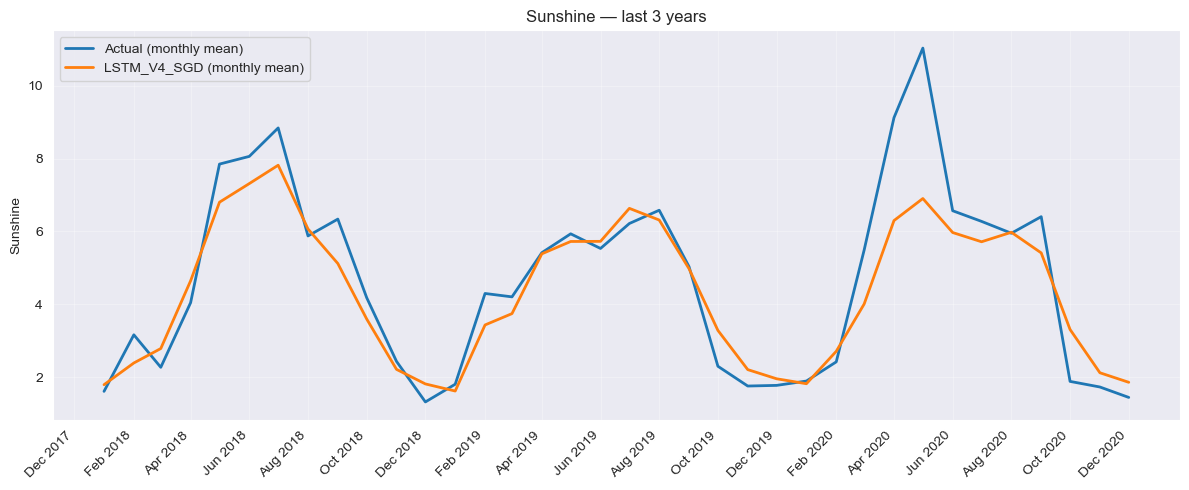

In [57]:
y_pred_lstm_v4_sgd, metrics_lstm_v4_sgd = evaluate_model(model_to_eval=model_lstm_v4_sgd,test_ds_to_eval=test_ds,x_test=X_test,model_version="LSTM_V4_SGD")

#### GRU

In [58]:
model_gru_v1_sgd = testOptimizerGRU(keras.optimizers.SGD(learning_rate=1e-3),model_name="model_gru_v1_sgd")

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 14, 32)            4224      
                                                                 
 dropout_13 (Dropout)        (None, 14, 32)            0         
                                                                 
 gru_13 (GRU)                (None, 16)                2400      
                                                                 
 dense_13 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 - 3s - loss: 21.2741 - root_mean_squared_error: 4.6124 - val_loss: 13.8253 - val_root_mean_squared_error: 3.7182 - lr: 0.0010 - 3s/epoch - 61ms/step
Epoch 2/100
52/5

Test loss: 11.53704
Test rmse: 3.39662
        Model       MAE        MSE      RMSE        R2
0  GRU_V1_SGD  2.751564  11.537039  3.396622  0.387368


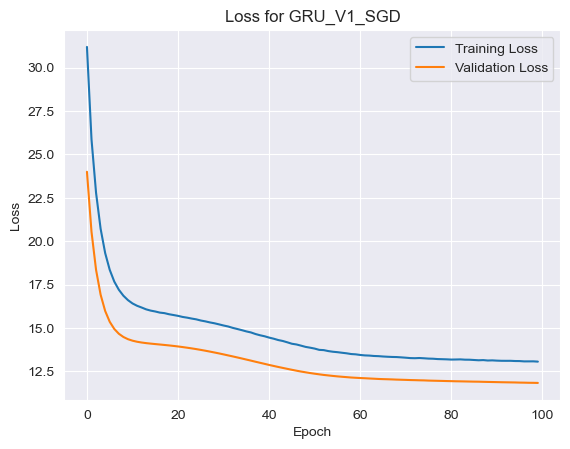

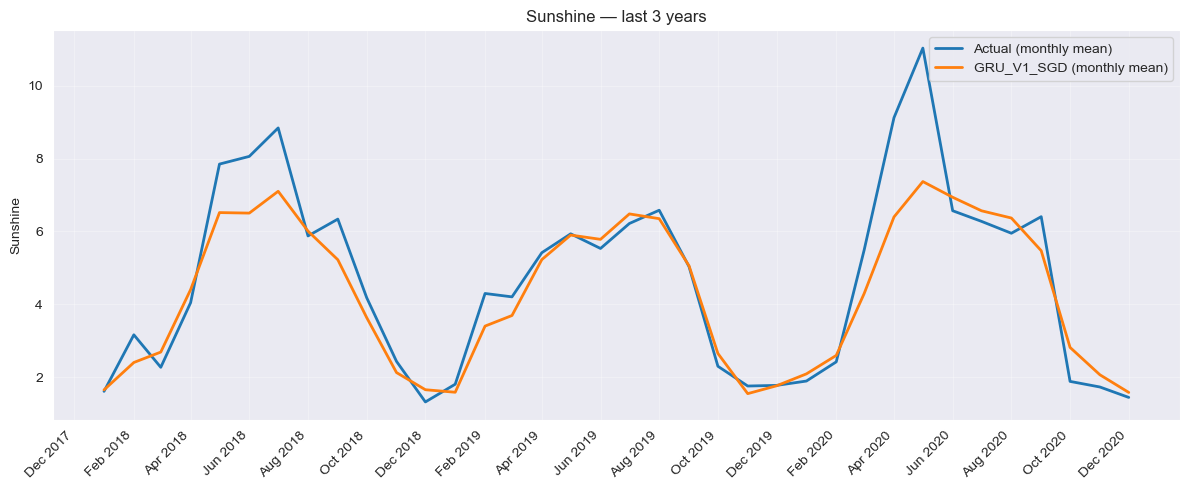

In [59]:
y_pred_gru_v1_sgd, metrics_gru_v1_sgd = evaluate_model(model_to_eval=model_gru_v1_sgd,test_ds_to_eval=test_ds,x_test=X_test,model_version="GRU_V1_SGD")

### ADAGRAD

#### LSTM

In [60]:
model_lstm_v4_adagrad = testOptimizerLSTM(keras.optimizers.Adagrad(learning_rate=1e-3),model_name="model_lstm_v4_adagrad")

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_7 (Bidirectio  (None, 14, 64)           11008     
 nal)                                                            
                                                                 
 layer_normalization_7 (Laye  (None, 14, 64)           128       
 rNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 14, 64)            0         
                                                                 
 lstm_15 (LSTM)              (None, 16)                5184      
                                                                 
 dense_14 (Dense)            (None, 1)                 17        
                                                                 
Total params: 16,337
Trainable params: 16,337
Non-tra

Test loss: 14.90029
Test rmse: 3.86009
             Model       MAE        MSE     RMSE        R2
0  LSTM_V4_ADAGRAD  3.124598  14.900292  3.86009  0.208775


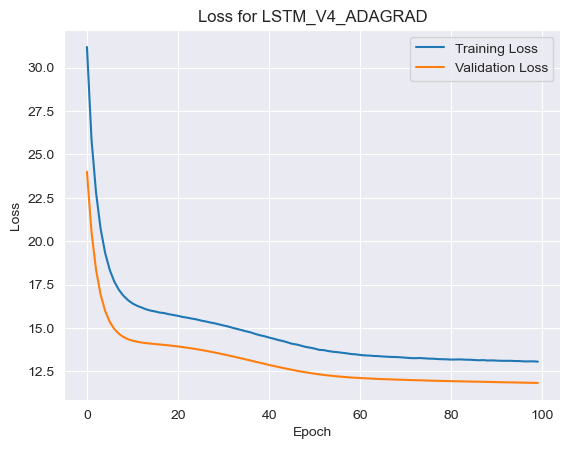

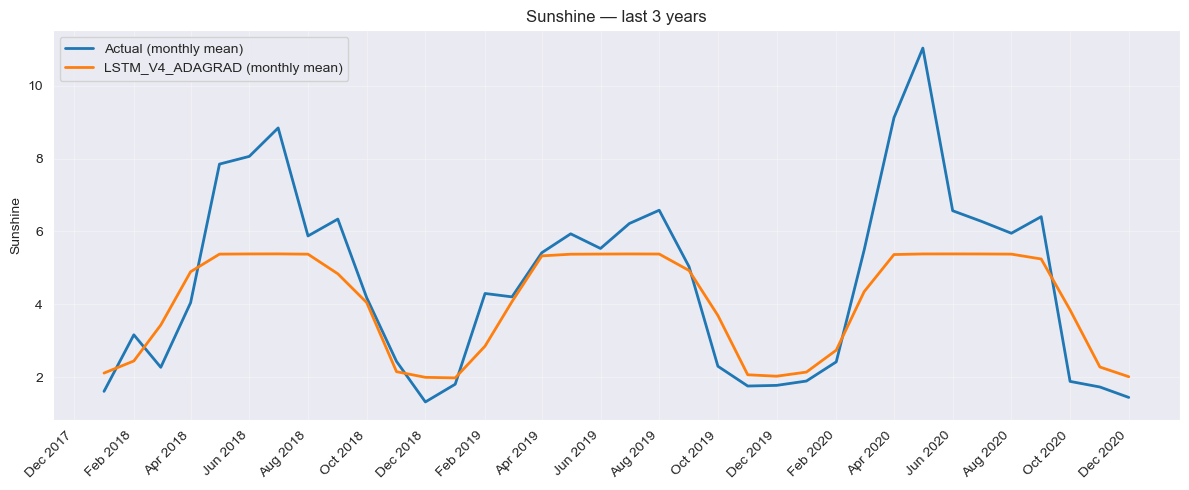

In [61]:
y_pred_lstm_v4_adagrad, metrics_lstm_v4_adagrad = evaluate_model(model_to_eval=model_lstm_v4_adagrad,test_ds_to_eval=test_ds,x_test=X_test,model_version="LSTM_V4_ADAGRAD")

#### GRU

In [62]:
model_gru_v1_adagrad = testOptimizerGRU(keras.optimizers.Adagrad(learning_rate=1e-3),model_name="model_gru_v1_adagrad")

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_14 (GRU)                (None, 14, 32)            4224      
                                                                 
 dropout_15 (Dropout)        (None, 14, 32)            0         
                                                                 
 gru_15 (GRU)                (None, 16)                2400      
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 6,641
Trainable params: 6,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
52/52 - 3s - loss: 31.9340 - root_mean_squared_error: 5.6510 - val_loss: 24.2408 - val_root_mean_squared_error: 4.9235 - lr: 0.0010 - 3s/epoch - 57ms/step
Epoch 2/100
52/5

Test loss: 14.36606
Test rmse: 3.79026
            Model       MAE        MSE      RMSE        R2
0  GRU_V1_ADAGRAD  3.096496  14.366058  3.790258  0.237143


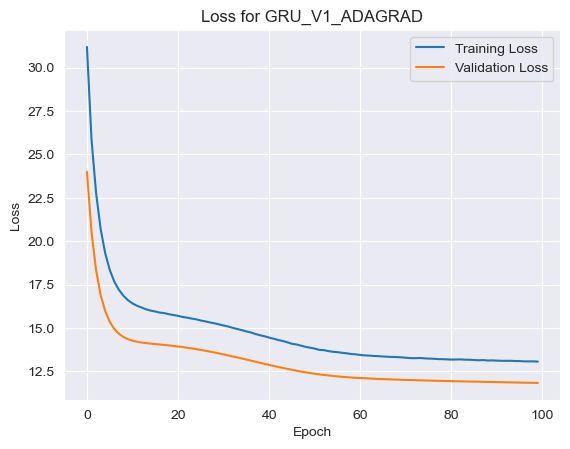

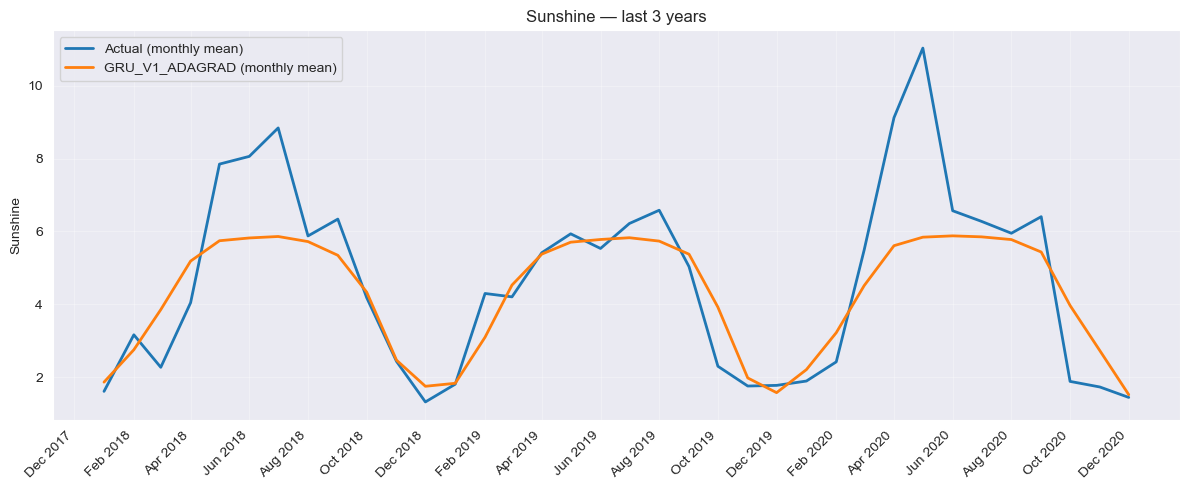

In [63]:
y_pred_gru_v1_adagrad, metrics_gru_v1_adagrad = evaluate_model(model_to_eval=model_gru_v1_adagrad,test_ds_to_eval=test_ds,x_test=X_test,model_version="GRU_V1_ADAGRAD")

### Optimizers Comparison

In [67]:
print(pd.concat([metrics_lstm_v4_adamax, metrics_lstm_v4_nadam, metrics_lstm_v4_sgd, metrics_lstm_v4_adagrad,
        metrics_gru_v1_adamax, metrics_gru_v1_nadam, metrics_gru_v1_sgd, metrics_gru_v1_adagrad
                 ], ignore_index=True).sort_values(by="R2",ascending=False))

             Model       MAE        MSE      RMSE        R2
1    LSTM_V4_NADAM  2.464842   8.961794  2.993626  0.524117
4    GRU_V1_ADAMAX  2.466801   9.021225  3.003535  0.520961
5     GRU_V1_NADAM  2.517300   9.294634  3.048710  0.506443
0   LSTM_V4_ADAMAX  2.523970   9.473289  3.077871  0.496956
2      LSTM_V4_SGD  2.559108   9.725001  3.118493  0.483590
6       GRU_V1_SGD  2.751564  11.537039  3.396622  0.387368
7   GRU_V1_ADAGRAD  3.096496  14.366058  3.790258  0.237143
3  LSTM_V4_ADAGRAD  3.124598  14.900292  3.860090  0.208775


LSTM

GRU

## OLD MODEL

In [170]:
# --- Windowing function ---
LOOKBACK = 7  # past 7 days

X, y = make_windows(features, target, LOOKBACK)
print("X shape:", X.shape)  # (num_samples, lookback, num_features)
print("y shape:", y.shape)  # (num_samples,)

X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y,LOOKBACK)

# --- Dataset pipeline ---
BATCH = 256

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(128).batch(BATCH).prefetch(2)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH).prefetch(2)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH).prefetch(2)

# --- Build LSTM classifier ---
F = X.shape[-1]  # number of features
model = keras.Sequential([
    keras.layers.Input(shape=(LOOKBACK, F)),
    keras.layers.GRU(64, return_sequences=True),
    keras.layers.Dropout(0.3),
    keras.layers.GRU(32,return_sequences=False),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1,activation="linear")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.losses.MeanSquaredError(),
    metrics=[tf.metrics.RootMeanSquaredError()]
)
model.summary()

# --- Train ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, min_lr=1e-5)
    ]
)


X shape: (15334, 7, 10)
y shape: (15334,)
Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 7, 64)             14592     
                                                                 
 dropout_80 (Dropout)        (None, 7, 64)             0         
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 layer_normalization_35 (Lay  (None, 32)               64        
 erNormalization)                                                
                                                                 
 dense_80 (Dense)            (None, 32)                1056      
                                                                 
 dropout_81 (Dropout)        (None, 32)                0         
           

5/5 [==============================] - 0s 4ms/step - loss: 8.3714 - root_mean_squared_error: 2.8933


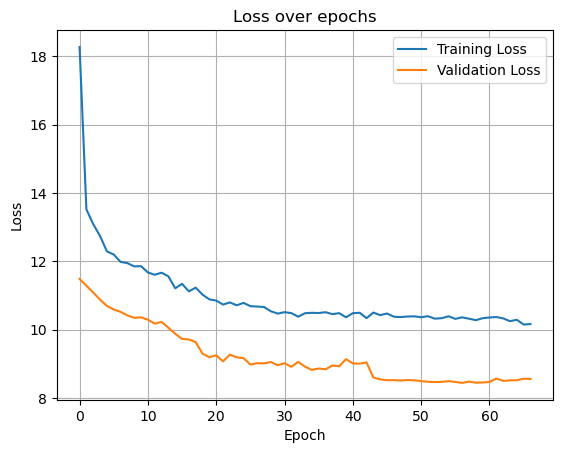

35/35 [==============================] - 1s 3ms/step


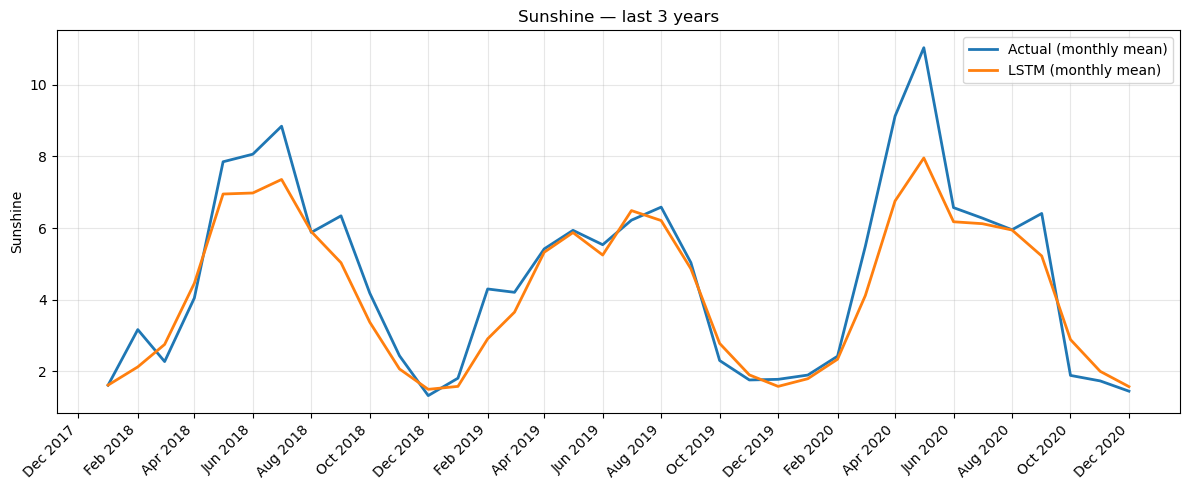

2.8933446407318115 8.371443748474121
Model      MAE      MSE     RMSE       R2
  GRU 2.350146 8.371443 2.893345 0.555465


In [77]:
test_loss, test_rmse = model.evaluate(test_ds)
plot_loss(history)
y_pred_gru = model.predict(X_test).ravel()
plot_test(y_test,y_pred_gru)
print(test_rmse,test_loss)
metrics_gru = eval_metrics("GRU",y_test, y_pred_gru)
print(metrics_gru.to_string(index=False))

## Testing some model

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# ==== 1) Skaliraj TARGET (y) – RNN-u mnogo olakša ====
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(target.values.reshape(-1, 1)).ravel()

LOOKBACK = 7  # probaj {7, 14, 30}
X, y = make_windows(features, pd.Series(y_scaled, index=target.index), LOOKBACK)
print("X shape:", X.shape)  # (N, lookback, F)
print("y shape:", y.shape)

X_train, y_train, X_val, y_val, X_test, y_test = make_split(X, y, LOOKBACK)

# ==== 2) tf.data – cache + AUTOTUNE + manji batch ====
AUTOTUNE = tf.data.AUTOTUNE
BATCH = 64  # probaj i 32

train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .cache()
    .shuffle(4096)
    .batch(BATCH)
    .prefetch(AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .cache()
    .batch(BATCH)
    .prefetch(AUTOTUNE)
)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH).prefetch(AUTOTUNE)

# ==== 3) Kompaktniji model – često bolji od dubokog stacka ====
F = X.shape[-1]

def build_model(cell="GRU", units=64, hidden=32, bidir=True, l2=1e-4, dropout=0.15, lr=3e-4):
    RNN = keras.layers.LSTM if cell.upper()=="LSTM" else keras.layers.GRU
    rnn = RNN(units, dropout=dropout, recurrent_dropout=0.0, return_sequences=False)
    if bidir:
        rnn = keras.layers.Bidirectional(rnn)

    inputs = keras.layers.Input(shape=(LOOKBACK, F))
    x = rnn(inputs)
    x = keras.layers.LayerNormalization()(x)
    x = keras.layers.Dense(hidden, activation="relu",
                           kernel_regularizer=keras.regularizers.l2(l2))(x)
    x = keras.layers.Dropout(dropout)(x)
    outputs = keras.layers.Dense(1, activation="linear")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(lr),
        loss="mse",
        metrics=[keras.metrics.RootMeanSquaredError(name="rmse")]
    )
    return model

# ➜ start sa GRU (češće pobedi na kraćim prozorima); probaj i cell="LSTM"
model = build_model(cell="GRU", units=64, hidden=32, bidir=False, l2=1e-4, dropout=0.15, lr=3e-4)
model.summary()

# ==== 4) Callbacks – mjeri šta ti je bitno i daj više vremena ====
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_rmse", patience=15, min_delta=1e-4,
                                  restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor="val_rmse", factor=0.5,
                                      patience=5, min_lr=1e-5, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=200, callbacks=callbacks, verbose=1)


X shape: (15334, 7, 11)
y shape: (15334,)
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 7, 11)]           0         
                                                                 
 gru_11 (GRU)                (None, 64)                14784     
                                                                 
 layer_normalization_11 (Lay  (None, 64)               128       
 erNormalization)                                                
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dropout_19 (Dropout)        (None, 32)                0         
                                                                 
 dense_23 (Dense)            (None, 1)                 33        
                 

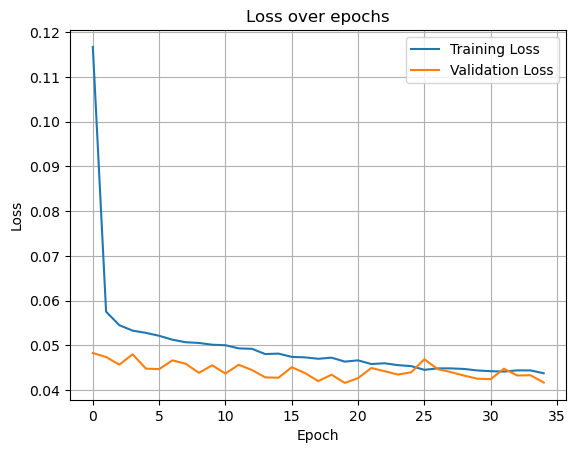

18/18 [==============================] - 0s 4ms/step


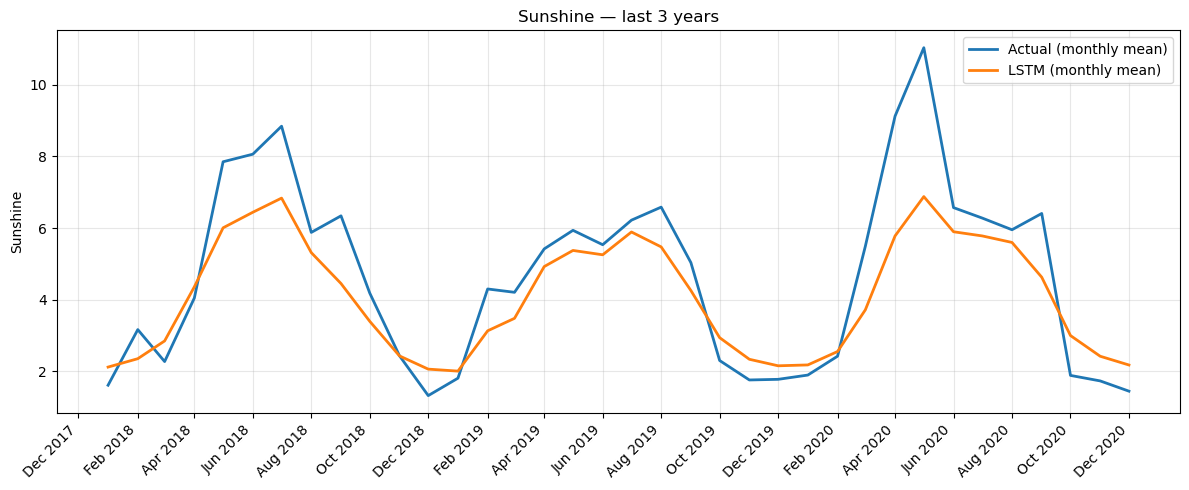

Model      MAE       MSE    RMSE       R2
  RNN 2.703194 10.947959 3.30877 0.418649


In [116]:
#test_loss, test_rmse = model.evaluate(test_ds)
plot_loss(history)
y_pred_scaled = model.predict(test_ds).ravel()
y_pred = y_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).ravel()
y_true = y_scaler.inverse_transform(y_test.reshape(-1,1)).ravel()
plot_test(y_true,y_pred)
#print(test_rmse,test_loss)
metrics_rnn = eval_metrics("RNN",y_true, y_pred)
print(metrics_rnn.to_string(index=False))

## Overview of all models

In [121]:
results = pd.concat([
    metrics_lstm,
    metrics_gru,
    metrics_rnn
])
results

Model       MAE        MSE      RMSE        R2
0  LSTM  2.394296   8.264122  2.874739  0.561164
0   GRU  2.350146   8.371443  2.893345  0.555465
0   RNN  2.703194  10.947959  3.308770  0.418649

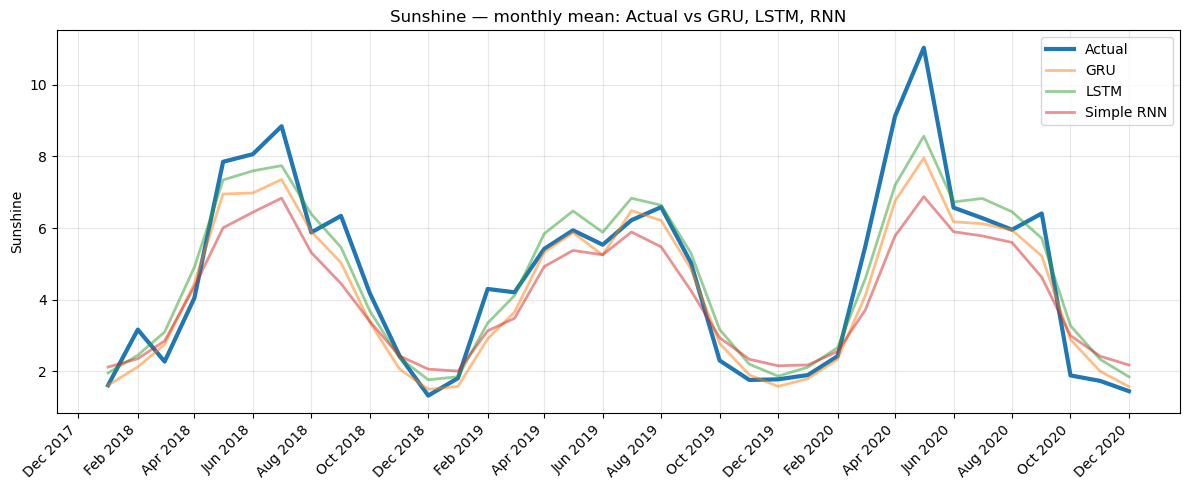

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

idx = pd.date_range("2018-01-01", periods=len(y_test), freq="D")

df_models = pd.DataFrame({
    "Actual": y_true,
    "GRU": y_pred_gru,
    "LSTM": y_pred_lstm_v1,
    "RNN": y_pred
}, index=idx)

# Mesečni prosek
df_monthly = df_models.resample("MS").mean()

fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_monthly.index, df_monthly["Actual"], lw=3, label="Actual")
ax.plot(df_monthly.index, df_monthly["GRU"], lw=2,alpha=0.5, label="GRU")
ax.plot(df_monthly.index, df_monthly["LSTM"], lw=2,alpha=0.5, label="LSTM")
ax.plot(df_monthly.index, df_monthly["RNN"], lw=2,alpha=0.5, label="Simple RNN")

ax.set_title("Sunshine — monthly mean: Actual vs GRU, LSTM, RNN")
ax.set_ylabel("Sunshine")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

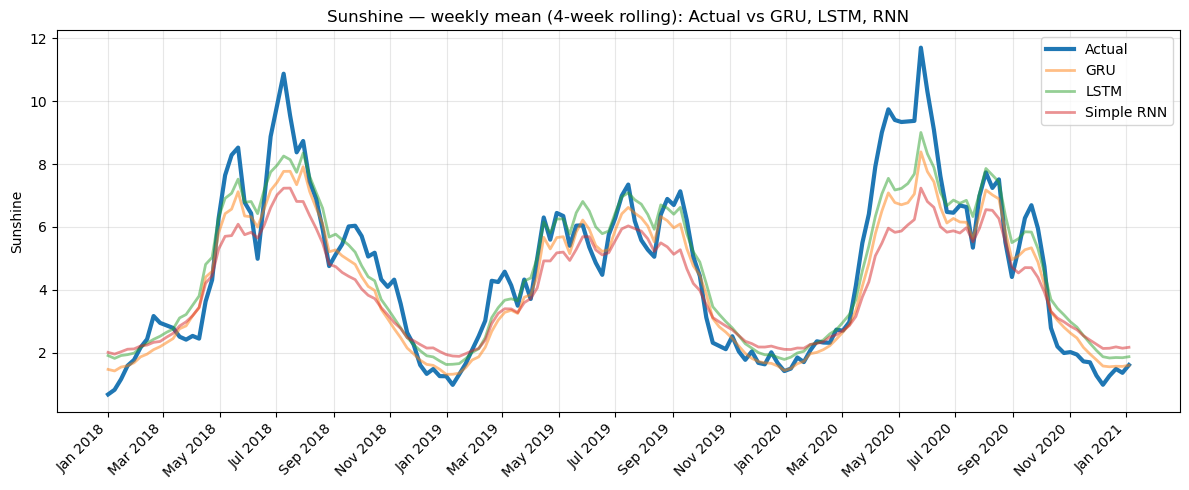

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

idx = pd.date_range("2018-01-01", periods=len(y_test), freq="D")

df_models = pd.DataFrame({
    "Actual": y_true,
    "GRU": y_pred_gru,
    "LSTM": y_pred_lstm_v1,
    "RNN": y_pred
}, index=idx)

# Mesečni prosek
df_weekly = df_models.resample("W-MON").mean()

df_weekly_roll = df_weekly.rolling(window=4, center=True, min_periods=2).mean()


fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_weekly_roll.index, df_weekly_roll["Actual"], lw=3, label="Actual")
ax.plot(df_weekly_roll.index, df_weekly_roll["GRU"], lw=2,alpha=0.5, label="GRU")
ax.plot(df_weekly_roll.index, df_weekly_roll["LSTM"], lw=2,alpha=0.5, label="LSTM")
ax.plot(df_weekly_roll.index, df_weekly_roll["RNN"], lw=2,alpha=0.5, label="Simple RNN")

ax.set_title("Sunshine — weekly mean (4-week rolling): Actual vs GRU, LSTM, RNN")
ax.set_ylabel("Sunshine")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

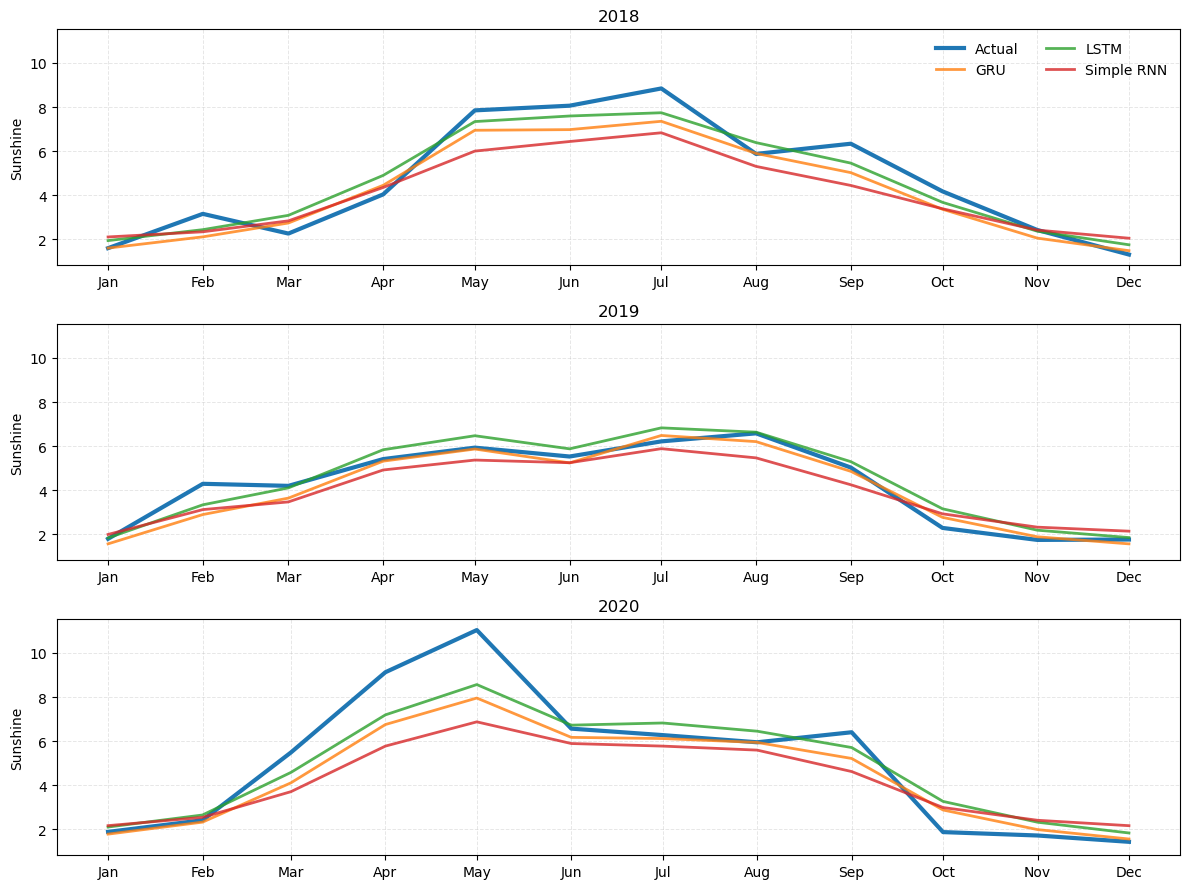

In [120]:
# 1) Monthly means
df_monthly = df_models.resample("MS").mean()

# 2) Last three years present (auto) — or set explicitly: years = [2018, 2019, 2020]
years = sorted(df_monthly.index.year.unique())[-3:]

import matplotlib.dates as mdates
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 9), sharey=True)

for ax, yr in zip(axes, years):
    m = df_monthly[df_monthly.index.year == yr]
    ax.plot(m.index, m["Actual"], lw=3, label="Actual")
    ax.plot(m.index, m["GRU"],   lw=2, alpha=0.8, label="GRU")
    ax.plot(m.index, m["LSTM"],  lw=2, alpha=0.8, label="LSTM")
    ax.plot(m.index, m["RNN"],   lw=2, alpha=0.8, label="Simple RNN")

    ax.set_title(f"{yr}")
    ax.set_ylabel("Sunshine")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.grid(True, alpha=0.3, linestyle="--", linewidth=0.7)

# Legend once (top panel)
axes[0].legend(frameon=False, ncol=2)
axes[-1].set_xlabel("")  # no global xlabel
plt.tight_layout()
plt.show()
